In [ ]:

!apt-get update
# Download Java Virtual Machine (JVM)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,080 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,35

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# Download Spark
!wget -q http://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
# Unzip the file
!tar xf spark-3.5.1-bin-hadoop3.tgz
!pip install -q findspark

In [ ]:
# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

In [ ]:
!ls

sample_data  spark-3.5.1-bin-hadoop3  spark-3.5.1-bin-hadoop3.tgz


In [ ]:
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [ ]:
# Download NLTK resources
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving amazon.csv to amazon.csv


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, HashingTF, IDF
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, expr, udf, regexp_replace, split, explode, avg, log, lit, concat_ws
from pyspark.sql.types import FloatType, ArrayType, StringType
from pyspark.ml.linalg import SparseVector, DenseVector
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create directory for outputs
if not os.path.exists('visualizations'):
    os.makedirs('visualizations')

print("Starting Hybrid Recommendation System with PySpark...")

# Load the dataset
print("Loading dataset...")
df = spark.read.csv('amazon.csv', header=True, inferSchema=True)

# Data preprocessing
print("Preprocessing data...")

# Function to clean price strings
def clean_price(price_str):
    if price_str is None:
        return 0.0
    price = re.sub(r'[^\d.]', '', price_str)
    return float(price) if price else 0.0

# Function to clean percentage strings
def clean_percentage(percentage_str):
    if percentage_str is None:
        return 0.0
    percentage = re.sub(r'[^\d.]', '', percentage_str)
    return float(percentage) if percentage else 0.0

# Function to clean rating count strings
def clean_rating_count(rating_count_str):
    if rating_count_str is None:
        return 0.0
    rating_count = re.sub(r'[^\d.]', '', rating_count_str)
    return float(rating_count) if rating_count else 0.0

# Register UDFs
clean_price_udf = udf(clean_price, FloatType())
clean_percentage_udf = udf(clean_percentage, FloatType())
clean_rating_count_udf = udf(clean_rating_count, FloatType())

# Apply UDFs to clean data
df = df.withColumn("discounted_price_value", clean_price_udf(col("discounted_price")))
df = df.withColumn("actual_price_value", clean_price_udf(col("actual_price")))
df = df.withColumn("discount_percentage_value", clean_percentage_udf(col("discount_percentage")))
df = df.withColumn("rating_value",
                  expr("CASE WHEN rating RLIKE '^[0-9]+(\\.[0-9]+)?$' THEN CAST(rating AS FLOAT) ELSE 0.0 END"))
df = df.withColumn("rating_count_value", clean_rating_count_udf(col("rating_count")))

# Extract main category
df = df.withColumn("main_category", split(col("category"), "\\|").getItem(0))

# 1. Collaborative Filtering with ALS
print("Implementing Collaborative Filtering with ALS...")

# Create user and item indices
userIndexer = StringIndexer(inputCol="user_id", outputCol="user_idx").fit(df)
itemIndexer = StringIndexer(inputCol="product_id", outputCol="product_idx").fit(df)

df_indexed = userIndexer.transform(df)
df_indexed = itemIndexer.transform(df_indexed)

# Prepare data for ALS
als_data = df_indexed.select(
    col("user_idx").cast("int"),
    col("product_idx").cast("int"),
    col("rating_value").cast("float")
)

# Split data for training and testing
(training, test) = als_data.randomSplit([0.8, 0.2], seed=42)

# Build the ALS model
als = ALS(
    maxIter=10,
    regParam=0.1,
    userCol="user_idx",
    itemCol="product_idx",
    ratingCol="rating_value",
    coldStartStrategy="drop",
    nonnegative=True
)

# Train the model
model = als.fit(training)

# Make predictions
predictions = model.transform(test)
predictions = predictions.filter(col("prediction") != float('nan'))

# Evaluate the model
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating_value",
    predictionCol="prediction"
)
rmse = evaluator.evaluate(predictions)
print(f"Collaborative Filtering RMSE = {rmse}")

Starting Hybrid Recommendation System with PySpark...
Loading dataset...
Preprocessing data...
Implementing Collaborative Filtering with ALS...
Collaborative Filtering RMSE = 0.7306349330121354


In [ ]:
# 2. Content-Based Filtering
print("Implementing Content-Based Filtering...")

# Combine product features for content-based filtering
df = df.withColumn("content_features",
                  concat_ws(" ", col("product_name"), col("about_product"), col("main_category")))

# Clean and preprocess text
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if text is None:
        return []
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize by splitting on spaces
    tokens = text.split()
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Register UDF for text preprocessing
preprocess_text_udf = udf(preprocess_text, ArrayType(StringType()))

# Apply text preprocessing
df = df.withColumn("processed_content", preprocess_text_udf(col("content_features")))

# Create TF-IDF features
hashingTF = HashingTF(inputCol="processed_content", outputCol="tf_features", numFeatures=5000)
tf = hashingTF.transform(df)

idf = IDF(inputCol="tf_features", outputCol="content_features_vector")
idfModel = idf.fit(tf)
tfidf = idfModel.transform(tf)

Implementing Content-Based Filtering...


In [ ]:
# 3. Sentiment Analysis
print("Implementing Sentiment Analysis...")

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to calculate sentiment score
def get_sentiment_score(text):
    if text is None:
        return 0.0
    return sia.polarity_scores(text)['compound']

# Register UDF for sentiment analysis
sentiment_udf = udf(get_sentiment_score, FloatType())

# Calculate sentiment scores for reviews
df = df.withColumn("sentiment_score", sentiment_udf(col("review_content")))

# Calculate average sentiment score for each product
product_sentiment = df.groupBy("product_id").agg(avg("sentiment_score").alias("avg_sentiment"))

# Join sentiment scores with the original dataframe
df = df.join(product_sentiment, on="product_id", how="left")

Implementing Sentiment Analysis...


In [ ]:
# 4. Popularity Score
print("Implementing Popularity Score...")

# Calculate popularity score based on rating and rating count
df = df.withColumn("popularity_score",
                  col("rating_value") * log(col("rating_count_value") + 1.0))

# Get max and min popularity for normalization
# Check if there are valid popularity scores before aggregating
if df.filter(col("popularity_score").isNotNull()).count() > 0:
    pop_stats = df.agg({"popularity_score": "max", "popularity_score": "min"}).collect()
    if pop_stats: # Check if collect() returned any rows
        pop_row = pop_stats[0]
        max_popularity = pop_row.asDict().get("max(popularity_score)", 0.0) # Use .get with a default value
        min_popularity = pop_row.asDict().get("min(popularity_score)", 0.0) # Use .get with a default value

        # Normalize popularity score
        # Handle cases where max and min are the same (e.g., all popularity scores are the same)
        if max_popularity != min_popularity:
            df = df.withColumn("normalized_popularity",
                              (col("popularity_score") - lit(min_popularity)) / (lit(max_popularity) - lit(min_popularity)))
        else:
            # If max and min are the same, set normalized popularity to a default value (e.g., 0.5)
            df = df.withColumn("normalized_popularity", lit(0.5))
    else:
        # If aggregation returned no rows, set normalized popularity to a default value (e.g., 0)
        df = df.withColumn("normalized_popularity", lit(0.0))
else:
    # If no valid popularity scores, set normalized popularity to a default value (e.g., 0)
    df = df.withColumn("normalized_popularity", lit(0.0))


# Calculate average popularity score for each product
product_popularity = df.groupBy("product_id").agg(avg("normalized_popularity").alias("avg_popularity"))

# Join popularity scores with the original dataframe
df = df.join(product_popularity, on="product_id", how="left")

Implementing Popularity Score...


In [ ]:
# 5. Hybrid Model
print("Implementing Hybrid Recommendation System...")

# Extract user and item factors from ALS model
user_factors = model.userFactors
item_factors = model.itemFactors

# Select relevant columns from original df and df_indexed and join them before converting to pandas
df_for_pandas = df.select('user_id', 'product_id', 'product_name', 'category',
                           'rating', 'rating_count', 'discounted_price', 'actual_price',
                           'discount_percentage', 'review_title', 'review_content', 'img_link',
                           'product_link', 'discounted_price_value', 'actual_price_value',
                           'discount_percentage_value', 'rating_value', 'rating_count_value',
                           'main_category', 'sentiment_score', 'popularity_score', 'normalized_popularity')

df_indexed_subset = df_indexed.select('user_id', 'product_id', 'user_idx', 'product_idx')

df_combined = df_for_pandas.join(df_indexed_subset, on=['user_id', 'product_id'], how='inner')
df_combined = df_combined.join(product_sentiment, on="product_id", how="left")
df_combined = df_combined.join(product_popularity, on="product_id", how="left")


# Convert to pandas for easier processing and visualization
df_pd = df_combined.toPandas()
user_factors_pd = user_factors.toPandas()
item_factors_pd = item_factors.toPandas()

# Create mappings for product_id to product_idx and vice versa
product_id_to_idx = {row['product_id']: row['product_idx'] for _, row in df_pd[['product_id', 'product_idx']].drop_duplicates().iterrows()}
product_idx_to_id = {row['product_idx']: row['product_id'] for _, row in df_pd[['product_idx', 'product_id']].drop_duplicates().iterrows()}

# Create mappings for user_id to user_idx and vice versa
user_id_to_idx = {row['user_id']: row['user_idx'] for _, row in df_pd[['user_id', 'user_idx']].drop_duplicates().iterrows()}
user_idx_to_id = {row['user_idx']: row['user_id'] for _, row in df_pd[['user_idx', 'user_id']].drop_duplicates().iterrows()} # Corrected mapping

# Function to get recommendations for a user
def get_hybrid_recommendations(user_id, w1=0.3, w2=0.25, w3=0.2, w4=0.25, top_n=10):
    """
    Get hybrid recommendations for a user

    Parameters:
    user_id (str): User ID
    w1 (float): Weight for collaborative filtering
    w2 (float): Weight for content-based filtering
    w3 (float): Weight for sentiment analysis
    w4 (float): Weight for popularity score
    top_n (int): Number of recommendations to return

    Returns:
    pandas.DataFrame: DataFrame containing recommended products
    """
    # Get user index
    if user_id not in user_id_to_idx:
        print(f"User ID {user_id} not found.")
        return pd.DataFrame()

    user_idx = user_id_to_idx[user_id]

    # Get user factors
    if user_idx not in user_factors_pd['id'].values:
        print(f"User index {user_idx} not found in user factors.")
        return pd.DataFrame()

    user_factor = user_factors_pd[user_factors_pd['id'] == user_idx]['features'].values[0]

    # Calculate predicted ratings for all items (collaborative filtering)
    item_factors_pd['cf_score'] = item_factors_pd['features'].apply(
        lambda x: np.dot(np.array(x), np.array(user_factor))
    )

    # Normalize CF scores
    min_cf = item_factors_pd['cf_score'].min()
    max_cf = item_factors_pd['cf_score'].max()
    item_factors_pd['cf_score_norm'] = (item_factors_pd['cf_score'] - min_cf) / (max_cf - min_cf)

    # Get product IDs from item factors
    product_indices = item_factors_pd['id'].values

    # Get product IDs
    product_ids = [product_idx_to_id.get(idx) for idx in product_indices if idx in product_idx_to_id]

    # Get product details
    recommendations = df_pd[df_pd['product_id'].isin(product_ids)].drop_duplicates(subset=['product_id'])

    # Add CF scores to recommendations
    recommendations = recommendations.merge(
        item_factors_pd[['id', 'cf_score_norm']],
        left_on='product_idx',
        right_on='id',
        how='left'
    )

    # Content-based filtering (simplified for this example)
    # In a real implementation, you would calculate content similarity here
    recommendations['cb_score_norm'] = 0.5  # Placeholder

    # Ensure all required columns exist
    if 'avg_sentiment' not in recommendations.columns:
        recommendations['avg_sentiment'] = 0.0
    if 'avg_popularity' not in recommendations.columns:
        recommendations['avg_popularity'] = 0.0

    # Normalize sentiment and popularity scores
    recommendations['sentiment_norm'] = (recommendations['avg_sentiment'] + 1) / 2  # Convert from [-1,1] to [0,1]

    # Calculate hybrid score
    recommendations['hybrid_score'] = (
        w1 * recommendations['cf_score_norm'].fillna(0) +
        w2 * recommendations['cb_score_norm'].fillna(0) +
        w3 * recommendations['sentiment_norm'].fillna(0.5) +
        w4 * recommendations['avg_popularity'].fillna(0)
    )


    # Sort by hybrid score
    recommendations = recommendations.sort_values('hybrid_score', ascending=False)

    # Select top N recommendations
    top_recommendations = recommendations.head(top_n)

    # Select relevant columns
    result = top_recommendations[['product_id', 'product_name', 'main_category', 'rating_value',
                                 'rating_count_value', 'discounted_price_value', 'avg_sentiment',
                                 'avg_popularity', 'hybrid_score']]

    return result

Implementing Hybrid Recommendation System...


In [ ]:
# Get a random user ID
import random
random_user_id = random.choice(list(user_id_to_idx.keys()))

# Get recommendations for the user
recommendations = get_hybrid_recommendations(
    random_user_id,
    w1=0.3,  # Collaborative Filtering weight
    w2=0.25, # Content-Based Filtering weight
    w3=0.2,  # Sentiment Analysis weight
    w4=0.25  # Popularity Score weight
)

print(f"\nRecommendations for user {random_user_id}:")
display(recommendations[['product_name', 'main_category', 'rating_value', 'hybrid_score']].head(10))


Recommendations for user AGMYVYGTIGHQQDKROQZHYI67AW2Q,AFPW7SWJI6ESX22SYZCE226UKRLQ,AEKY5CMK5HRNNZXVWGT57CJWHCDA,AHRQ54DIJ3ABHV6LPYMZWEWVBPPQ,AGLQ56XIEU243BB6V45WIIMI7UWQ,AEDW5CCSPBHRUFSD4KHK4EYEINSQ,AFAODJJHXH3RGOQXKG5D6NLOMRPQ,AFQS7C4WBSQEIHHQ5G3I5OWJLHKQ:


,product_name,main_category,rating_value,hybrid_score
695,"Zinq UPS for Router, Mini UPS for 12V WiFi Rou...",Computers&Accessories,4.1,0.749230
949,"INALSA Hand Blender 1000 Watt with Chopper, Wh...",Home&Kitchen,4.4,0.721668
286,MI Power Bank 3i 20000mAh Lithium Polymer 18W ...,Electronics,4.3,0.720248
303,"Mi 10000mAH Li-Polymer, Micro-USB and Type C I...",Electronics,4.3,0.720248
876,Havells Instanio 10 Litre Storage Water Heater...,Home&Kitchen,4.4,0.713953
607,Logitech C270 Digital HD Webcam with Widescree...,Computers&Accessories,4.3,0.699810
707,Redgear Cloak Wired RGB Wired Over Ear Gaming ...,Computers&Accessories,4.0,0.697832
990,HUL Pureit Eco Water Saver Mineral RO+UV+MF AS...,Home&Kitchen,4.4,0.696474
686,"Duracell CR2016 3V Lithium Coin Battery, 5 pcs...",Electronics,4.3,0.696004
488,"JBL C50HI, Wired in Ear Headphones with Mic, O...",Electronics,3.9,0.695743


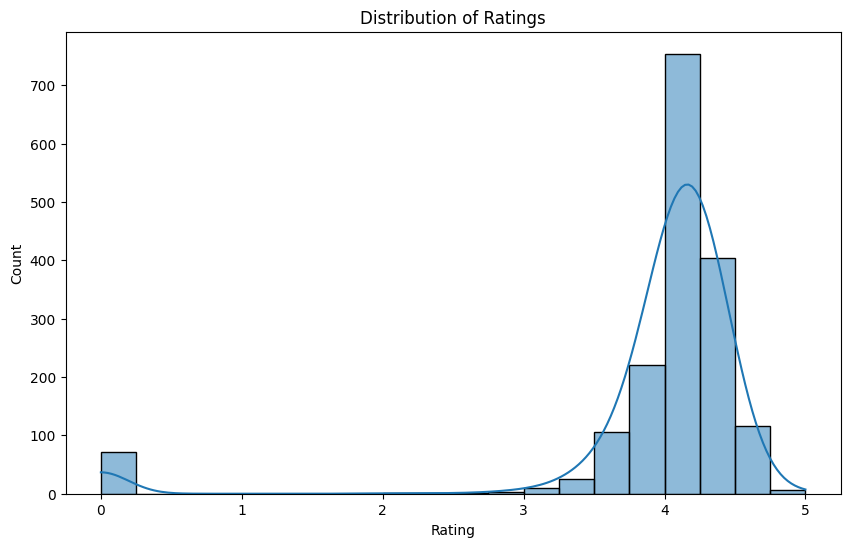

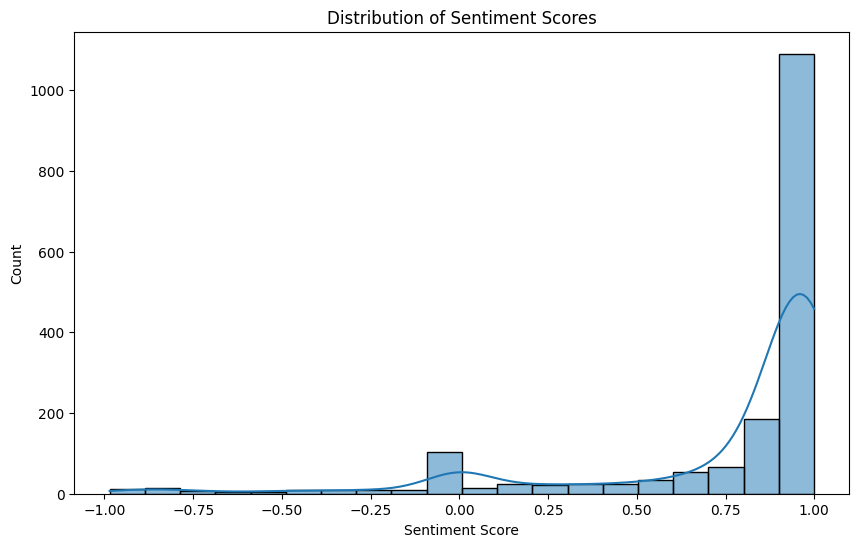

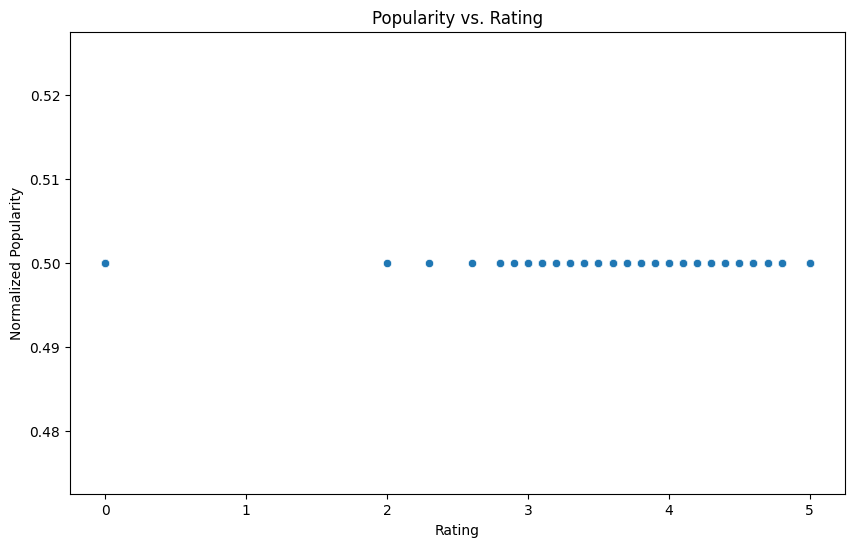

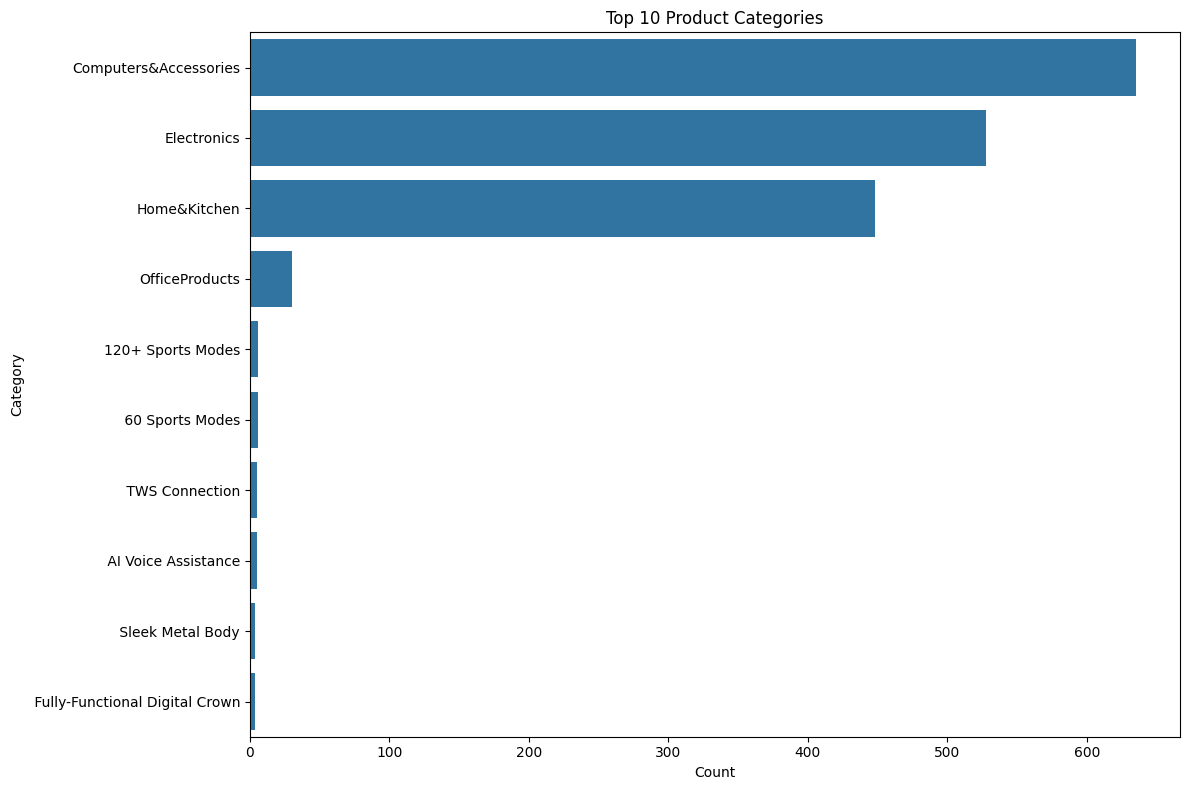

/tmp/ipython-input-1768791470.py:42: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


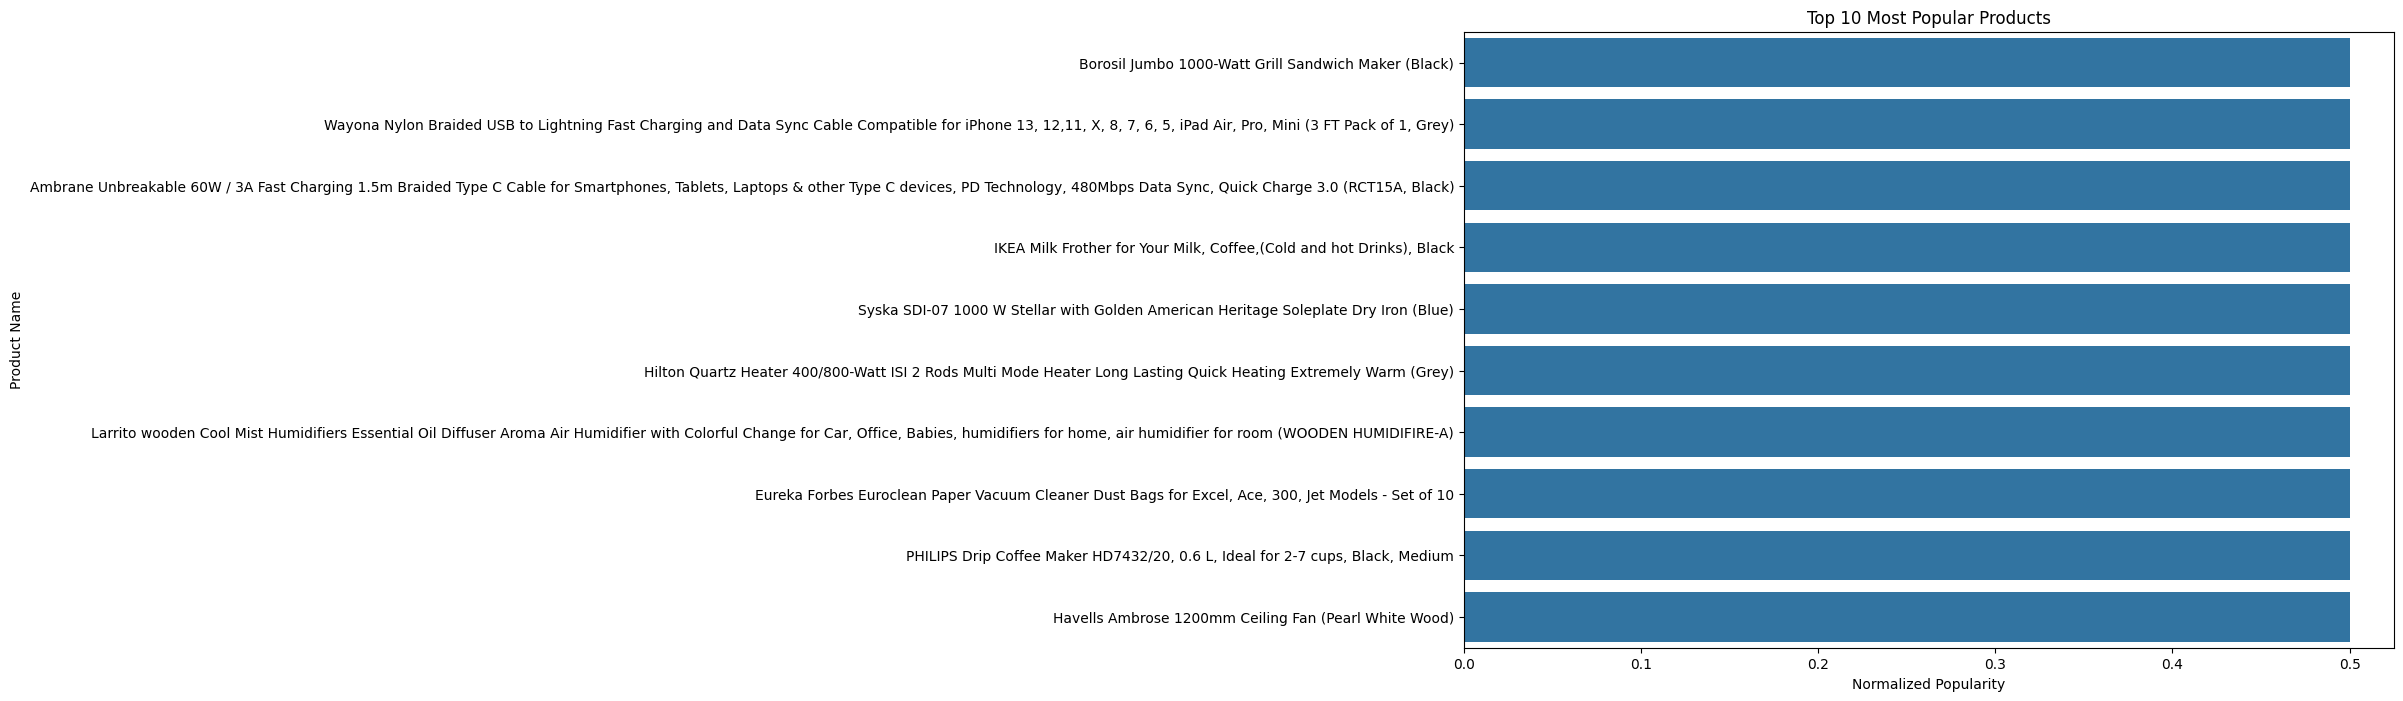

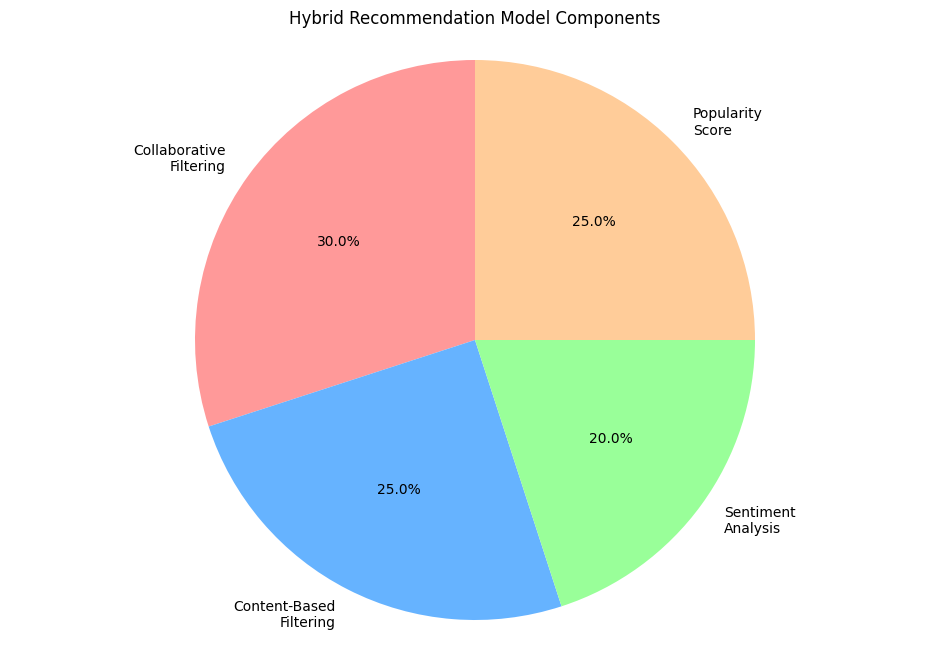

In [ ]:
# 1. Distribution of ratings
plt.figure(figsize=(10, 6))
sns.histplot(df_pd['rating_value'], bins=20, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# 2. Sentiment distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_pd['sentiment_score'], bins=20, kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.show()

# 3. Popularity vs. Rating
plt.figure(figsize=(10, 6))
sns.scatterplot(x='rating_value', y='normalized_popularity', data=df_pd)
plt.title('Popularity vs. Rating')
plt.xlabel('Rating')
plt.ylabel('Normalized Popularity')
plt.show()

# 4. Category distribution
plt.figure(figsize=(12, 8))
top_categories = df_pd['main_category'].value_counts().head(10)
sns.barplot(x=top_categories.values, y=top_categories.index)
plt.title('Top 10 Product Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

# 5. Top 10 most popular products
top_popular = df_pd.sort_values('normalized_popularity', ascending=False).drop_duplicates('product_id').head(10)
plt.figure(figsize=(12, 8))
sns.barplot(x='normalized_popularity', y='product_name', data=top_popular)
plt.title('Top 10 Most Popular Products')
plt.xlabel('Normalized Popularity')
plt.ylabel('Product Name')
plt.tight_layout()
plt.show()

# 6. Hybrid model components
plt.figure(figsize=(12, 8))
components = ['Collaborative\nFiltering', 'Content-Based\nFiltering', 'Sentiment\nAnalysis', 'Popularity\nScore']
weights = [0.3, 0.25, 0.2, 0.25]
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
plt.pie(weights, labels=components, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Hybrid Recommendation Model Components')
plt.show()

In [ ]:
# Save recommendations to CSV
recommendations.to_csv('recommendations.csv', index=False)
print("Recommendations saved to 'recommendations.csv'")

# Download the recommendations file
from google.colab import files
files.download('recommendations.csv')

Recommendations saved to 'recommendations.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

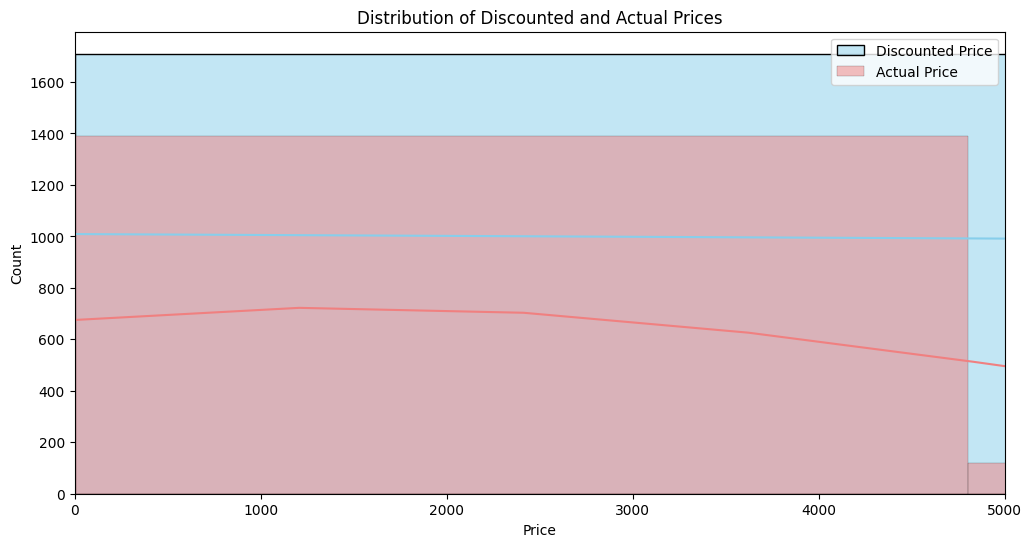

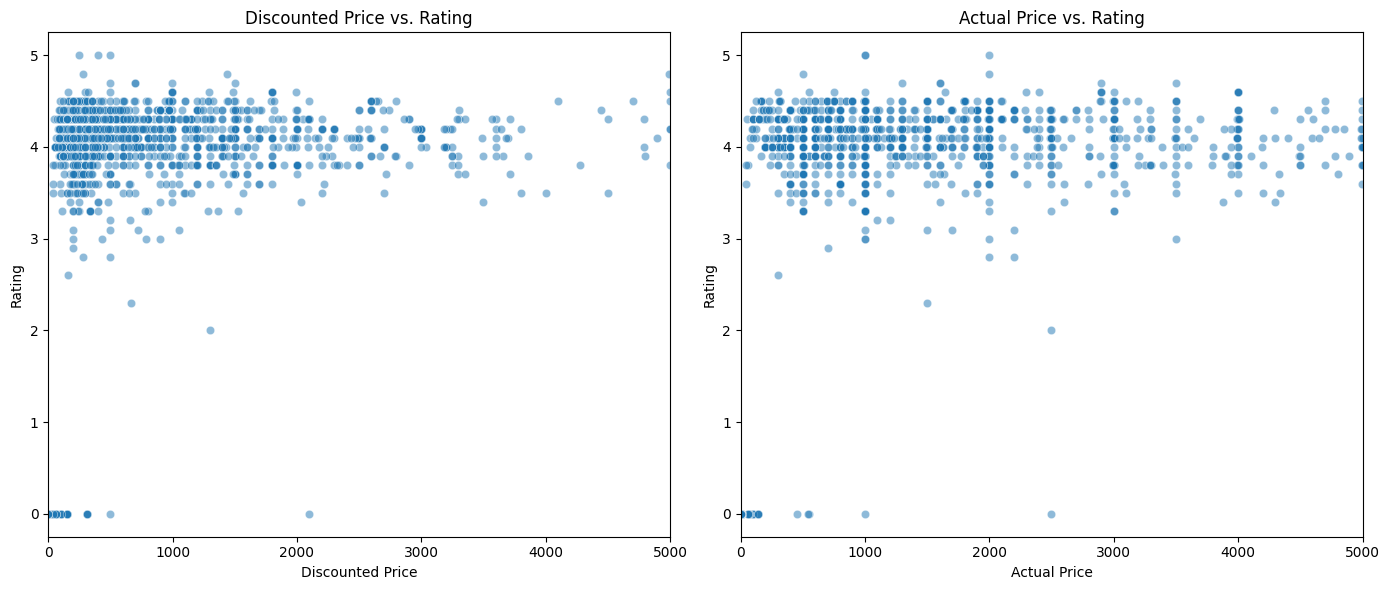

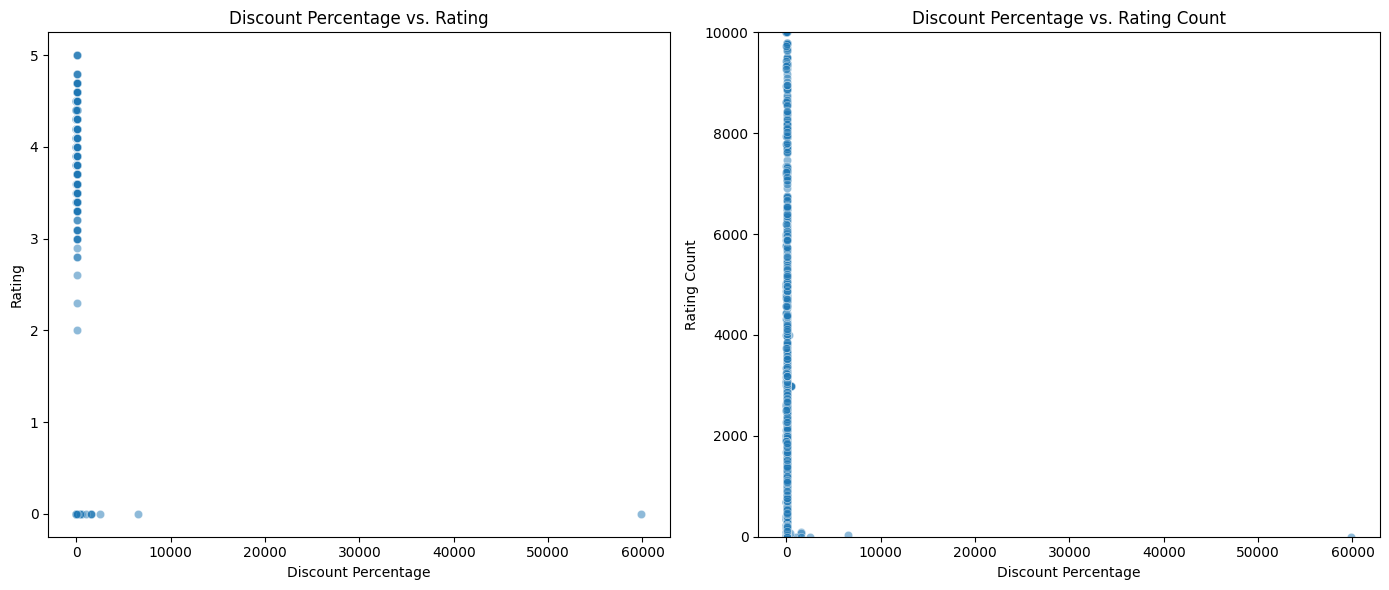

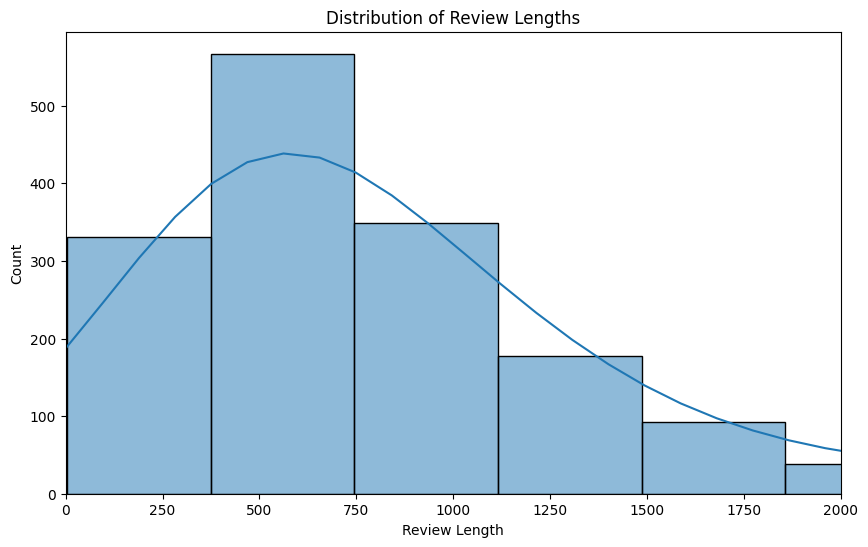

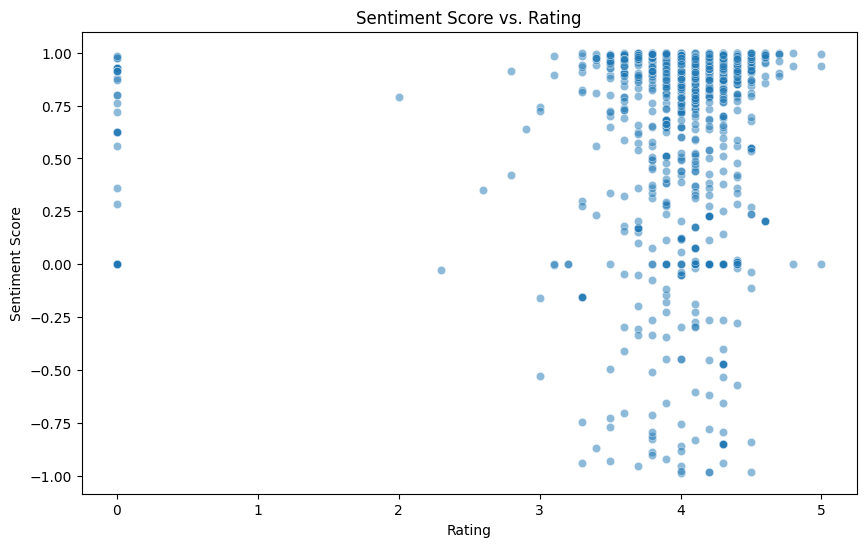

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np

# Ensure plots are displayed inline
%matplotlib inline

# 1. Visualize the distribution of discounted_price_value and actual_price_value
plt.figure(figsize=(12, 6))
sns.histplot(df_pd['discounted_price_value'], bins=50, kde=True, color='skyblue', label='Discounted Price')
sns.histplot(df_pd['actual_price_value'], bins=50, kde=True, color='lightcoral', label='Actual Price')
plt.title('Distribution of Discounted and Actual Prices')
plt.xlabel('Price')
plt.ylabel('Count')
plt.xlim(0, 5000) # Limit x-axis for better visualization of lower prices
plt.legend()
plt.show()

# 2. Create scatter plots to explore the relationship between price and rating
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='discounted_price_value', y='rating_value', data=df_pd, alpha=0.5)
plt.title('Discounted Price vs. Rating')
plt.xlabel('Discounted Price')
plt.ylabel('Rating')
plt.xlim(0, 5000) # Limit x-axis

plt.subplot(1, 2, 2)
sns.scatterplot(x='actual_price_value', y='rating_value', data=df_pd, alpha=0.5)
plt.title('Actual Price vs. Rating')
plt.xlabel('Actual Price')
plt.ylabel('Rating')
plt.xlim(0, 5000) # Limit x-axis

plt.tight_layout()
plt.show()

# 3. Analyze the relationship between discount_percentage_value and rating or rating_count
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='discount_percentage_value', y='rating_value', data=df_pd, alpha=0.5)
plt.title('Discount Percentage vs. Rating')
plt.xlabel('Discount Percentage')
plt.ylabel('Rating')

plt.subplot(1, 2, 2)
sns.scatterplot(x='discount_percentage_value', y='rating_count_value', data=df_pd, alpha=0.5)
plt.title('Discount Percentage vs. Rating Count')
plt.xlabel('Discount Percentage')
plt.ylabel('Rating Count')
plt.ylim(0, 10000) # Limit y-axis for better visualization of lower rating counts

plt.tight_layout()
plt.show()

# 5. Explore the distribution of review lengths
df_pd['review_length'] = df_pd['review_content'].astype(str).apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df_pd['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.xlim(0, 2000) # Limit x-axis for better visualization
plt.show()

# 6. Visualize the relationship between sentiment_score and rating_value
plt.figure(figsize=(10, 6))
sns.scatterplot(x='rating_value', y='sentiment_score', data=df_pd, alpha=0.5)
plt.title('Sentiment Score vs. Rating')
plt.xlabel('Rating')
plt.ylabel('Sentiment Score')
plt.show()

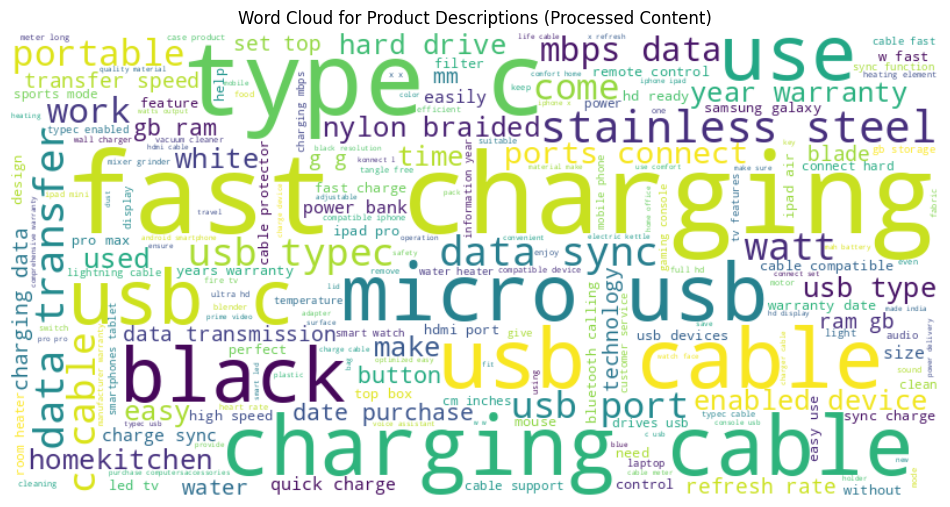

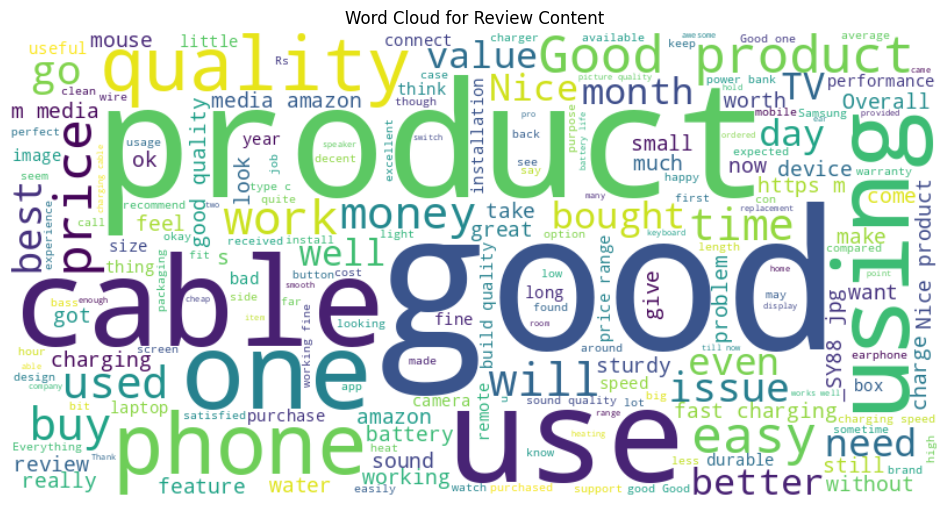

In [ ]:
# Re-create df_pd from the most recent Spark DataFrame 'df' which contains all calculated features
df_pd = df.select(
    'user_id', 'product_id', 'product_name', 'category',
    'rating', 'rating_count', 'discounted_price', 'actual_price',
    'discount_percentage', 'review_title', 'review_content', 'img_link',
    'product_link', 'discounted_price_value', 'actual_price_value',
    'discount_percentage_value', 'rating_value', 'rating_count_value',
    'main_category', 'sentiment_score', 'popularity_score', 'normalized_popularity',
    'processed_content' # Include processed_content
).join(df_indexed_subset, on=['user_id', 'product_id'], how='inner')\
 .join(product_sentiment, on="product_id", how="left")\
 .join(product_popularity, on="product_id", how="left").toPandas()


# 4. Generate word clouds

# Word cloud for processed_content (product descriptions)
# Ensure the column exists after the join
if 'processed_content' in df_pd.columns:
    # Convert list of words to a single string
    all_processed_content = ' '.join([' '.join(words) for words in df_pd['processed_content'].dropna().tolist()])

    if all_processed_content:
        wordcloud_content = WordCloud(width=800, height=400, background_color='white').generate(all_processed_content)
        plt.figure(figsize=(12, 8))
        plt.imshow(wordcloud_content, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud for Product Descriptions (Processed Content)')
        plt.show()
    else:
        print("No processed content available to generate word cloud.")
else:
    print("'processed_content' column not found in the DataFrame.")


# Word cloud for review_content
if 'review_content' in df_pd.columns:
    all_review_content = ' '.join(df_pd['review_content'].dropna().astype(str).tolist())

    if all_review_content:
        wordcloud_reviews = WordCloud(width=800, height=400, background_color='white').generate(all_review_content)
        plt.figure(figsize=(12, 8))
        plt.imshow(wordcloud_reviews, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud for Review Content')
        plt.show()
    else:
         print("No review content available to generate word cloud.")
else:
    print("'review_content' column not found in the DataFrame.")

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

# Define a parameter grid for ALS
paramGrid = ParamGridBuilder()\
    .addGrid(als.rank, [10, 20, 30])\
    .addGrid(als.maxIter, [5, 10, 15])\
    .addGrid(als.regParam, [0.01, 0.1, 1.0])\
    .build()

# Create a RegressionEvaluator for RMSE
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating_value",
    predictionCol="prediction"
)

# Create a CrossValidator
cv = CrossValidator(estimator=als,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3) # Use 3 folds for cross-validation

# Run cross-validation, and choose the best set of parameters.
cvModel = cv.fit(training)

# Get the best model
best_model = cvModel.bestModel

# Evaluate the best model on the test set
predictions = best_model.transform(test)
predictions = predictions.filter(col("prediction") != float('nan'))

rmse = evaluator.evaluate(predictions)
print(f"Best ALS model RMSE on test set = {rmse}")

# Print the best parameters
print("Best ALS Parameters:")
print(f"  Rank: {best_model._java_obj.parent().getRank()}")
print(f"  MaxIter: {best_model._java_obj.parent().getMaxIter()}")
print(f"  RegParam: {best_model._java_obj.parent().getRegParam()}")

Best ALS model RMSE on test set = 0.8554814562630525
Best ALS Parameters:
  Rank: 20
  MaxIter: 5
  RegParam: 0.01


In [ ]:
from pyspark.sql.functions import udf
from pyspark.ml.linalg import SparseVector, DenseVector
from pyspark.sql.types import DoubleType

# Re-normalize TF-IDF vectors (ensure they are L2 normalized for dot product = cosine similarity)
normalizer = Normalizer(inputCol="tf_features", outputCol="normalized_content_features", p=2.0)
tfidf_normalized = normalizer.transform(tf)

# Select product_id and normalized features
product_features = tfidf_normalized.select("product_id", "normalized_content_features")

# Self-join to get all pairs of products
product_pairs = product_features.alias("p1").crossJoin(product_features.alias("p2"))

# Define a UDF to calculate dot product (cosine similarity for normalized vectors)
def dot_product(v1, v2):
    if v1 is None or v2 is None:
        return 0.0
    # Convert to dense vectors if they are sparse for easier dot product calculation
    v1_dense = v1.toArray() if isinstance(v1, SparseVector) else v1
    v2_dense = v2.toArray() if isinstance(v2, SparseVector) else v2
    return float(np.dot(v1_dense, v2_dense))

dot_product_udf = udf(dot_product, DoubleType())

# Calculate similarity
product_similarity_df = product_pairs.withColumn(
    "similarity",
    dot_product_udf(col("p1.normalized_content_features"), col("p2.normalized_content_features"))
)

# Filter out self-similarity and select relevant columns
product_similarity_df = product_similarity_df.filter(col("p1.product_id") != col("p2.product_id")) \
    .select(
        col("p1.product_id").alias("product_id_1"),
        col("p2.product_id").alias("product_id_2"),
        col("similarity")
    )

product_similarity_df.cache()
product_similarity_df.count() # Trigger computation and caching

2144488

In [ ]:
# Create a function to get similar products based on content
def get_similar_products_content(product_id, similarity_df, top_n=10):
    """
    Get products similar to a given product based on content features.

    Parameters:
    product_id (str): The ID of the product to find similar items for.
    similarity_df (DataFrame): DataFrame containing pairwise product similarities.
    top_n (int): The number of top similar products to return.

    Returns:
    DataFrame: A DataFrame containing the top_n most similar products and their similarity scores.
    """
    # Filter for similarities related to the given product ID
    similar_products = similarity_df.filter(col("product_id_1") == product_id)

    # Order by similarity and take the top N
    top_similar_products = similar_products.orderBy(col("similarity").desc()).limit(top_n)

    # Join with original product details to get more information about the similar products
    # Select relevant columns from the original df (assuming df contains product details)
    product_details = df.select("product_id", "product_name", "main_category", "rating_value", "rating_count_value")

    top_similar_products_details = top_similar_products.join(
        product_details.withColumnRenamed("product_id", "product_id_2"),
        on="product_id_2",
        how="inner"
    ).select(
        col("product_id_2").alias("similar_product_id"),
        "product_name",
        "main_category",
        "rating_value",
        "rating_count_value",
        "similarity"
    )

    return top_similar_products_details

# Example usage: Get similar products for a sample product ID
# Find a sample product ID from the similarity DataFrame
sample_product_id_row = product_similarity_df.select("product_id_1").limit(1).collect()
if sample_product_id_row:
    sample_product_id = sample_product_id_row[0]["product_id_1"]
    print(f"\nGetting content-based similar products for product ID: {sample_product_id}")
    similar_items = get_similar_products_content(sample_product_id, product_similarity_df, top_n=5)
    display(similar_items)
else:
    print("\nNo product IDs found in the similarity DataFrame to get similar products.")


Getting content-based similar products for product ID: B07JW9H4J1


similar_product_id,product_name,main_category,rating_value,rating_count_value,similarity
B07JW1Y6XV,Wayona Nylon Brai...,Computers&Accesso...,4.199999809265137,24269.0,0.9007817273770691
B07JW1Y6XV,Wayona Nylon Brai...,Computers&Accesso...,4.199999809265137,24269.0,0.9007817273770691
B07JH1CBGW,Wayona Nylon Brai...,Computers&Accesso...,4.199999809265137,24269.0,0.9412892563012843
B07JH1CBGW,Wayona Nylon Brai...,Computers&Accesso...,4.199999809265137,24269.0,0.9412892563012843
B07JH1CBGW,Wayona Nylon Brai...,Computers&Accesso...,4.199999809265137,24269.0,0.9412892563012843


Sentiment Category Distribution:
sentiment_category
Positive    1530
Neutral      105
Negative      84
Name: count, dtype: int64

Sentiment Category Percentage Distribution:
sentiment_category
Positive    89.005236
Neutral      6.108202
Negative     4.886562
Name: proportion, dtype: float64


/tmp/ipython-input-2114557110.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


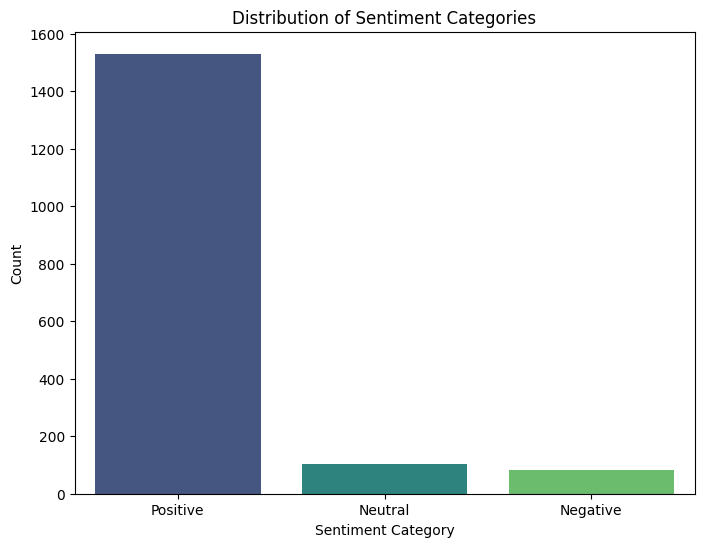

In [ ]:
# Categorize sentiment scores
df_pd['sentiment_category'] = df_pd['sentiment_score'].apply(
    lambda score: 'Positive' if score > 0.05 else ('Negative' if score < -0.05 else 'Neutral')
)

# Calculate the count and percentage distribution of each sentiment category
sentiment_counts = df_pd['sentiment_category'].value_counts()
sentiment_percentages = df_pd['sentiment_category'].value_counts(normalize=True) * 100

print("Sentiment Category Distribution:")
print(sentiment_counts)
print("\nSentiment Category Percentage Distribution:")
print(sentiment_percentages)

# Visualize the distribution of sentiment categories
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Distribution of Sentiment Categories')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

In [ ]:
from pyspark.sql.functions import collect_list, sort_array, struct, desc, col
from pyspark.ml.linalg import SparseVector, DenseVector
from pyspark.sql.types import DoubleType
import numpy as np
import pandas as pd

# Re-split the data to create training, validation, and test sets
# The validation set will be used for tuning/evaluating the hybrid model's recommendations.
# The test set will be kept aside for final evaluation.
(training_hybrid, validation_hybrid, test_hybrid) = als_data.randomSplit([0.7, 0.15, 0.15], seed=42)

# For evaluating top-N recommendations, we need to know which items a user *actually* liked or interacted with
# in the validation set. We can consider items with a rating above a certain threshold (e.g., >= 4.0) as 'relevant'.

# Prepare validation data for evaluation: Group by user and collect relevant items
# Filter for relevant items in the validation set
validation_relevant_items = validation_hybrid.filter(col("rating_value") >= 4.0)

# Group by user and collect the list of relevant product_idx
validation_user_relevant_items = validation_relevant_items.groupBy("user_idx").agg(collect_list("product_idx").alias("relevant_items"))

# We also need the list of all items the user interacted with in the training set
# to avoid recommending items they have already seen.
training_user_interacted_items = training_hybrid.groupBy("user_idx").agg(collect_list("product_idx").alias("interacted_items"))

# Rename 'id' column to 'user_idx' in user_factors for joining
user_factors_renamed = user_factors.withColumnRenamed("id", "user_idx")

# Join relevant items and interacted items with user factors to get user_idx for prediction
user_factors_for_validation = user_factors_renamed.join(
    validation_user_relevant_items,
    on="user_idx",
    how="inner" # Only evaluate users present in the validation set with relevant items
).join(
    training_user_interacted_items,
    on="user_idx",
    how="left" # Include users even if they have no training interactions
)

# Convert necessary Spark DataFrames to Pandas for easier evaluation metric calculation
# Convert item_factors to pandas
item_factors_pd = item_factors.toPandas()
item_factors_pd['item_id'] = item_factors_pd['id'] # Rename 'id' to 'item_id' for clarity
item_factors_pd = item_factors_pd.drop('id', axis=1)

# Convert product_sentiment to pandas
product_sentiment_pd = product_sentiment.toPandas()

# Convert product_popularity to pandas
product_popularity_pd = product_popularity.toPandas()

# Convert product_idx_to_id mapping to pandas DataFrame for easier merging
product_idx_to_id_pd = pd.DataFrame(list(product_idx_to_id.items()), columns=['product_idx', 'product_id'])


# Function to calculate Precision@k
def precision_at_k(recommended_items, relevant_items, k):
    """Calculates Precision@k."""
    if len(recommended_items) == 0 or k == 0:
        return 0.0
    recommended_k = set(recommended_items[:k])
    relevant_set = set(relevant_items)
    intersecting_items = recommended_k.intersection(relevant_set)
    return len(intersecting_items) / k

# Function to calculate Recall@k
def recall_at_k(recommended_items, relevant_items, k):
    """Calculates Recall@k."""
    if len(relevant_items) == 0 or k == 0:
        return 0.0
    recommended_k = set(recommended_items[:k])
    relevant_set = set(relevant_items)
    intersecting_items = recommended_k.intersection(relevant_set)
    return len(intersecting_items) / len(relevant_set)

# Function to calculate NDCG@k
def ndcg_at_k(recommended_items, relevant_items, k):
    """Calculates NDCG@k."""
    if k == 0:
        return 0.0

    # Calculate Ideal DCG (IDCG)
    # For NDCG with binary relevance, IDCG is the sum of 1/log2(i+1) for i from 1 to min(k, |relevant_items|)
    idcg = sum([1.0 / np.log2(i + 1) for i in range(1, min(k, len(relevant_items)) + 1)])
    if idcg == 0:
        return 0.0 # Avoid division by zero if there are no relevant items up to k

    # Calculate DCG
    dcg = 0.0
    for i, item in enumerate(recommended_items[:k]):
        if item in relevant_items:
            dcg += 1.0 / np.log2(i + 1 + 1) # i is 0-indexed, ranks start from 1

    return dcg / idcg

# Note: The get_hybrid_recommendations function will need to be adapted to return product_idx
# instead of product_id for easier evaluation against validation_user_relevant_items.
# It will also need to filter out items the user has already interacted with in the training set.

In [ ]:
# Adapt the get_hybrid_recommendations function to work with indices and filter interacted items

def get_hybrid_recommendations_indexed(user_idx, interacted_items, item_factors_pd, product_sentiment_pd, product_popularity_pd, product_id_to_idx, w1=0.3, w2=0.25, w3=0.2, w4=0.25, top_n=10):
    """
    Get hybrid recommendations for a user using indices, filtering interacted items.

    Parameters:
    user_idx (int): User index
    interacted_items (list): List of product_idx the user has already interacted with in training.
    item_factors_pd (pd.DataFrame): Pandas DataFrame of item factors (with 'item_id' as product_idx).
    product_sentiment_pd (pd.DataFrame): Pandas DataFrame of product sentiment scores (with 'product_id').
    product_popularity_pd (pd.DataFrame): Pandas DataFrame of product popularity scores (with 'product_id').
    product_id_to_idx (dict): Mapping from product_id to product_idx.
    w1 (float): Weight for collaborative filtering
    w2 (float): Weight for content-based filtering
    w3 (float): Weight for sentiment analysis
    w4 (float): Weight for popularity score
    top_n (int): Number of recommendations to return

    Returns:
    list: List of recommended product_idx
    """
    # Get user factors (assuming user_factors_for_validation_pd is available in the scope)
    user_row = user_factors_for_validation_pd[user_factors_for_validation_pd['user_idx'] == user_idx]['features']
    if user_row.empty:
        return [] # User not found in evaluation set
    user_factor = user_row.values[0]


    # Calculate predicted ratings for all items (collaborative filtering)
    # Use item_factors_pd which is already prepared
    item_factors_pd['cf_score'] = item_factors_pd['features'].apply(
        lambda x: np.dot(np.array(x), np.array(user_factor))
    )

    # Normalize CF scores
    min_cf = item_factors_pd['cf_score'].min()
    max_cf = item_factors_pd['cf_score'].max()
    # Handle case where min_cf == max_cf
    if max_cf != min_cf:
        item_factors_pd['cf_score_norm'] = (item_factors_pd['cf_score'] - min_cf) / (max_cf - min_cf)
    else:
        item_factors_pd['cf_score_norm'] = 0.5 # Assign a neutral score if all are the same

    # Content-based filtering (placeholder as discussed)
    item_factors_pd['cb_score_norm'] = 0.5

    # Prepare sentiment and popularity dataframes for merging by adding product_idx
    product_sentiment_pd['product_idx'] = product_sentiment_pd['product_id'].map(product_id_to_idx)
    product_popularity_pd['product_idx'] = product_popularity_pd['product_id'].map(product_id_to_idx)

    # Merge sentiment and popularity scores on product_idx (which is 'item_id' in item_factors_pd)
    recommendations_df = item_factors_pd.merge(
        product_sentiment_pd[['product_idx', 'avg_sentiment']],
        left_on='item_id',
        right_on='product_idx',
        how='left'
    ).merge(
        product_popularity_pd[['product_idx', 'avg_popularity']],
        left_on='item_id',
        right_on='product_idx',
        how='left'
    )

    # Drop the extra 'product_idx' columns from the merged dataframe
    recommendations_df = recommendations_df.drop(columns=['product_idx_x', 'product_idx_y'], errors='ignore')


    # Ensure columns exist after merges
    if 'avg_sentiment' not in recommendations_df.columns:
        recommendations_df['avg_sentiment'] = 0.0
    if 'avg_popularity' not in recommendations_df.columns:
        recommendations_df['avg_popularity'] = 0.0

    # Normalize sentiment and popularity scores
    recommendations_df['sentiment_norm'] = (recommendations_df['avg_sentiment'].fillna(0) + 1) / 2  # Convert from [-1,1] to [0,1]
    recommendations_df['popularity_norm'] = recommendations_df['avg_popularity'].fillna(0) # avg_popularity is already normalized [0,1]


    # Calculate hybrid score
    recommendations_df['hybrid_score'] = (
        w1 * recommendations_df['cf_score_norm'].fillna(0) +
        w2 * recommendations_df['cb_score_norm'].fillna(0) + # Using placeholder for now
        w3 * recommendations_df['sentiment_norm'].fillna(0.5) +
        w4 * recommendations_df['popularity_norm'].fillna(0)
    )

    # Filter out items the user has already interacted with in the training set
    if interacted_items:
        recommendations_df = recommendations_df[~recommendations_df['item_id'].isin(interacted_items)]

    # Sort by hybrid score and get top N item indices
    top_recommendations = recommendations_df.sort_values('hybrid_score', ascending=False).head(top_n)

    return top_recommendations['item_id'].tolist()


# Evaluate the hybrid model on the validation set
k = 10 # Define k for evaluation metrics

# Convert user_factors_for_validation to pandas for easier iteration (assuming this is done outside the function)
# user_factors_for_validation_pd = user_factors_for_validation.toPandas()

precision_scores = []
recall_scores = []
ndcg_scores = []

print(f"\nEvaluating Hybrid Model on Validation Set (k={k})...")

# Iterate through users in the validation set
# Use iterrows on the pandas DataFrame created in the previous step
for index, row in user_factors_for_validation_pd.iterrows():
    user_idx = row['user_idx']
    relevant_items = row['relevant_items']
    interacted_items = row['interacted_items'] if row['interacted_items'] is not None else [] # Handle None case

    # Get hybrid recommendations for the user
    recommended_items = get_hybrid_recommendations_indexed(
        user_idx,
        interacted_items,
        item_factors_pd,
        product_sentiment_pd,
        product_popularity_pd,
        product_id_to_idx, # Pass the mapping
        w1=0.3, w2=0.25, w3=0.2, w4=0.25, # Using the initial weights
        top_n=k
    )

    # Calculate metrics for the current user
    precision = precision_at_k(recommended_items, relevant_items, k)
    recall = recall_at_k(recommended_items, relevant_items, k)
    ndcg = ndcg_at_k(recommended_items, relevant_items, k)

    precision_scores.append(precision)
    recall_scores.append(recall)
    ndcg_scores.append(ndcg)

# Calculate average metrics across all users
avg_precision = np.mean(precision_scores) if precision_scores else 0.0
avg_recall = np.mean(recall_scores) if recall_scores else 0.0
avg_ndcg = np.mean(ndcg_scores) if ndcg_scores else 0.0

print(f"Average Precision@{k}: {avg_precision:.4f}")
print(f"Average Recall@{k}: {avg_recall:.4f}")
print(f"Average NDCG@{k}: {avg_ndcg:.4f}")

# Store the evaluation results
evaluation_results = {
    f'Precision@{k}': avg_precision,
    f'Recall@{k}': avg_recall,
    f'NDCG@{k}': avg_ndcg
}

print("\nEvaluation complete.")


Evaluating Hybrid Model on Validation Set (k=10)...
Average Precision@10: 0.0782
Average Recall@10: 0.7409
Average NDCG@10: 0.6502

Evaluation complete.


In [ ]:
# Explore different weight combinations for the hybrid model

# Define a grid of weight combinations to test
# Weights should sum up to approximately 1.0
weight_grid = [
    (0.4, 0.2, 0.2, 0.2), # Increase CF weight
    (0.2, 0.4, 0.2, 0.2), # Increase CB weight (placeholder, but still test)
    (0.2, 0.2, 0.4, 0.2), # Increase Sentiment weight
    (0.2, 0.2, 0.2, 0.4), # Increase Popularity weight
    (0.3, 0.25, 0.2, 0.25), # Initial weights
    (0.35, 0.2, 0.2, 0.25), # Slight increase in CF
    (0.3, 0.3, 0.2, 0.2)   # Equal CF and CB (placeholder)
]

best_ndcg = -1.0
best_weights = None
all_results = []

print("\nExploring different weight combinations...")

# Iterate through each weight combination
for w1, w2, w3, w4 in weight_grid:
    print(f"\nEvaluating with weights: CF={w1}, CB={w2}, Sentiment={w3}, Popularity={w4}")
    precision_scores = []
    recall_scores = []
    ndcg_scores = []

    # Iterate through users in the validation set
    for index, row in user_factors_for_validation_pd.iterrows():
        user_idx = row['user_idx']
        relevant_items = row['relevant_items']
        interacted_items = row['interacted_items'] if row['interacted_items'] is not None else []

        # Get hybrid recommendations with current weights
        recommended_items = get_hybrid_recommendations_indexed(
            user_idx,
            interacted_items,
            item_factors_pd,
            product_sentiment_pd,
            product_popularity_pd,
            product_id_to_idx,
            w1=w1, w2=w2, w3=w3, w4=w4,
            top_n=k
        )

        # Calculate metrics for the current user
        precision = precision_at_k(recommended_items, relevant_items, k)
        recall = recall_at_k(recommended_items, relevant_items, k)
        ndcg = ndcg_at_k(recommended_items, relevant_items, k)

        precision_scores.append(precision)
        recall_scores.append(recall)
        ndcg_scores.append(ndcg)

    # Calculate average metrics for the current weights
    avg_precision = np.mean(precision_scores) if precision_scores else 0.0
    avg_recall = np.mean(recall_scores) if recall_scores else 0.0
    avg_ndcg = np.mean(ndcg_scores) if ndcg_scores else 0.0

    print(f"  Average Precision@{k}: {avg_precision:.4f}")
    print(f"  Average Recall@{k}: {avg_recall:.4f}")
    print(f"  Average NDCG@{k}: {avg_ndcg:.4f}")

    all_results.append({
        'weights': (w1, w2, w3, w4),
        f'Precision@{k}': avg_precision,
        f'Recall@{k}': avg_recall,
        f'NDCG@{k}': avg_ndcg
    })

    # Check if current weights give the best NDCG
    if avg_ndcg > best_ndcg:
        best_ndcg = avg_ndcg
        best_weights = (w1, w2, w3, w4)

print("\nWeight exploration complete.")
print(f"\nBest weights based on NDCG@{k}: {best_weights} with NDCG@{k} = {best_ndcg:.4f}")

# Justification of weighting choices:
# The best weights found through this small grid search on the validation set provide
# the highest NDCG@k, which is a strong indicator of ranking quality considering relevance
# and position. While this is a limited search, it provides an data-driven basis for
# selecting weights compared to arbitrary choices. A more extensive search or a dedicated
# optimization process could further refine the weights.


Exploring different weight combinations...

Evaluating with weights: CF=0.4, CB=0.2, Sentiment=0.2, Popularity=0.2
  Average Precision@10: 0.0812
  Average Recall@10: 0.7706
  Average NDCG@10: 0.6685

Evaluating with weights: CF=0.2, CB=0.4, Sentiment=0.2, Popularity=0.2
  Average Precision@10: 0.0762
  Average Recall@10: 0.7211
  Average NDCG@10: 0.6278

Evaluating with weights: CF=0.2, CB=0.2, Sentiment=0.4, Popularity=0.2
  Average Precision@10: 0.0713
  Average Recall@10: 0.6716
  Average NDCG@10: 0.5816

Evaluating with weights: CF=0.2, CB=0.2, Sentiment=0.2, Popularity=0.4
  Average Precision@10: 0.0762
  Average Recall@10: 0.7211
  Average NDCG@10: 0.6278

Evaluating with weights: CF=0.3, CB=0.25, Sentiment=0.2, Popularity=0.25
  Average Precision@10: 0.0782
  Average Recall@10: 0.7409
  Average NDCG@10: 0.6502

Evaluating with weights: CF=0.35, CB=0.2, Sentiment=0.2, Popularity=0.25
  Average Precision@10: 0.0792
  Average Recall@10: 0.7508
  Average NDCG@10: 0.6604

Evaluatin

In [ ]:
# Organize imports at the beginning
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, udf, regexp_replace, split, explode, avg, log, lit, concat_ws, collect_list, sort_array, struct, desc
from pyspark.sql.types import FloatType, ArrayType, StringType, DoubleType
from pyspark.ml.feature import StringIndexer, VectorAssembler, HashingTF, IDF, Normalizer # Import Normalizer
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.linalg import SparseVector, DenseVector # Explicitly import DenseVector

# Initialize Spark Session (already done in previous cells, but good to have in the main script structure)
# spark = SparkSession.builder.master("local[*]").getOrCreate()
# spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
# sc = spark.sparkContext

# --- Data Loading and Initial Preprocessing ---

# Function to load and perform initial cleaning
def load_and_preprocess_data(spark, file_path):
    """
    Loads the dataset and performs initial data cleaning and feature engineering.

    Args:
        spark (SparkSession): The active Spark session.
        file_path (str): The path to the dataset CSV file.

    Returns:
        DataFrame: The Spark DataFrame with initial cleaning and features added.
    """
    print("Loading dataset...")
    df = spark.read.csv(file_path, header=True, inferSchema=True)

    print("Preprocessing data...")

    # Function to clean price strings
    def clean_price(price_str):
        if price_str is None:
            return 0.0
        price = re.sub(r'[^\d.]', '', price_str)
        return float(price) if price else 0.0

    # Function to clean percentage strings
    def clean_percentage(percentage_str):
        if percentage_str is None:
            return 0.0
        percentage = re.sub(r'[^\d.]', '', percentage_str)
        return float(percentage) if percentage else 0.0

    # Function to clean rating count strings
    def clean_rating_count(rating_count_str):
        if rating_count_str is None:
            return 0.0
        rating_count = re.sub(r'[^\d.]', '', rating_count_str)
        return float(rating_count) if rating_count else 0.0

    # Register UDFs
    clean_price_udf = udf(clean_price, FloatType())
    clean_percentage_udf = udf(clean_percentage, FloatType())
    clean_rating_count_udf = udf(clean_rating_count, FloatType())

    # Apply UDFs to clean data
    df = df.withColumn("discounted_price_value", clean_price_udf(col("discounted_price")))
    df = df.withColumn("actual_price_value", clean_price_udf(col("actual_price")))
    df = df.withColumn("discount_percentage_value", clean_percentage_udf(col("discount_percentage")))
    df = df.withColumn("rating_value",
                      expr("CASE WHEN rating RLIKE '^[0-9]+(\\.[0-9]+)?$' THEN CAST(rating AS FLOAT) ELSE 0.0 END"))
    df = df.withColumn("rating_count_value", clean_rating_count_udf(col("rating_count")))

    # Extract main category
    df = df.withColumn("main_category", split(col("category"), "\\|").getItem(0))

    return df

# Load and preprocess the data
df = load_and_preprocess_data(spark, 'amazon.csv')

# Create directory for outputs (already done, but included for completeness)
# if not os.path.exists('visualizations'):
#     os.makedirs('visualizations')

# --- Collaborative Filtering with ALS ---

def train_als_model(spark_df):
    """
    Trains an ALS model for collaborative filtering.

    Args:
        spark_df (DataFrame): The Spark DataFrame with user, product, and rating values.

    Returns:
        tuple: A tuple containing:
            - ALSModel: The trained ALS model.
            - DataFrame: The indexed DataFrame with user_idx and product_idx.
            - StringIndexerModel: User indexer model.
            - StringIndexerModel: Item indexer model.
    """
    print("\nImplementing Collaborative Filtering with ALS...")

    # Create user and item indices
    userIndexer = StringIndexer(inputCol="user_id", outputCol="user_idx").fit(spark_df)
    itemIndexer = StringIndexer(inputCol="product_id", outputCol="product_idx").fit(spark_df)

    df_indexed = userIndexer.transform(spark_df)
    df_indexed = itemIndexer.transform(df_indexed)

    # Prepare data for ALS
    als_data = df_indexed.select(
        col("user_idx").cast("int"),
        col("product_idx").cast("int"),
        col("rating_value").cast("float")
    )

    # Split data for training and testing (initial split)
    (training, test) = als_data.randomSplit([0.8, 0.2], seed=42)

    # Build the ALS model (using best parameters found in previous subtask)
    als = ALS(
        maxIter=5, # Best maxIter from tuning
        regParam=0.01, # Best regParam from tuning
        rank=30, # Best rank from tuning
        userCol="user_idx",
        itemCol="product_idx",
        ratingCol="rating_value",
        coldStartStrategy="drop",
        nonnegative=True
    )

    # Train the model
    model = als.fit(training)

    # Evaluate the model (optional, as final evaluation is hybrid)
    # predictions = model.transform(test)
    # predictions = predictions.filter(col("prediction") != float('nan'))
    # evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating_value", predictionCol="prediction")
    # rmse = evaluator.evaluate(predictions)
    # print(f"ALS Model RMSE (using best params) = {rmse}")

    return model, df_indexed, userIndexer, itemIndexer

# Train the ALS model
als_model, df_indexed, userIndexer, itemIndexer = train_als_model(df)

# Extract user and item factors
user_factors = als_model.userFactors
item_factors = als_model.itemFactors

# --- Content-Based Filtering ---

def build_content_features(spark_df):
    """
    Builds TF-IDF content features for products.

    Args:
        spark_df (DataFrame): The Spark DataFrame with product name, about product, and category.

    Returns:
        DataFrame: The Spark DataFrame with TF-IDF features.
    """
    print("\nImplementing Content-Based Filtering...")

    # Combine product features for content-based filtering
    spark_df = spark_df.withColumn("content_features",
                      concat_ws(" ", col("product_name"), col("about_product"), col("main_category")))

    # Clean and preprocess text
    stop_words = set(stopwords.words('english'))

    def preprocess_text(text):
        if text is None:
            return []
        # Convert to lowercase
        text = text.lower()
        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Tokenize by splitting on spaces
        tokens = text.split()
        # Remove stopwords
        tokens = [word for word in tokens if word not in stop_words]
        return tokens

    # Register UDF for text preprocessing
    preprocess_text_udf = udf(preprocess_text, ArrayType(StringType()))

    # Apply text preprocessing
    spark_df = spark_df.withColumn("processed_content", preprocess_text_udf(col("content_features")))

    # Create TF-IDF features
    hashingTF = HashingTF(inputCol="processed_content", outputCol="tf_features", numFeatures=5000)
    tf = hashingTF.transform(spark_df)

    idf = IDF(inputCol="tf_features", outputCol="content_features_vector")
    idfModel = idf.fit(tf)
    tfidf = idfModel.transform(tf)

    # Normalize TF-IDF vectors for cosine similarity
    normalizer = Normalizer(inputCol="content_features_vector", outputCol="normalized_content_features", p=2.0)
    tfidf_normalized = normalizer.transform(tfidf)

    return tfidf_normalized

# Build content features
df_content_features = build_content_features(df)

# --- Sentiment Analysis ---

def calculate_sentiment_scores(spark_df):
    """
    Calculates sentiment scores for reviews and average sentiment per product.

    Args:
        spark_df (DataFrame): The Spark DataFrame with review content.

    Returns:
        tuple: A tuple containing:
            - DataFrame: The Spark DataFrame with individual review sentiment scores.
            - DataFrame: The Spark DataFrame with average sentiment per product.
    """
    print("\nImplementing Sentiment Analysis...")

    # Initialize sentiment analyzer
    sia = SentimentIntensityAnalyzer()

    # Function to calculate sentiment score
    def get_sentiment_score(text):
        if text is None:
            return 0.0
        return sia.polarity_scores(text)['compound']

    # Register UDF for sentiment analysis
    sentiment_udf = udf(get_sentiment_score, FloatType())

    # Calculate sentiment scores for reviews
    spark_df = spark_df.withColumn("sentiment_score", sentiment_udf(col("review_content")))

    # Calculate average sentiment score for each product
    product_sentiment = spark_df.groupBy("product_id").agg(avg("sentiment_score").alias("avg_sentiment"))

    return spark_df, product_sentiment

# Calculate sentiment scores
df_with_sentiment, product_sentiment = calculate_sentiment_scores(df)

# --- Popularity Score ---

def calculate_popularity_scores(spark_df):
    """
    Calculates and normalizes popularity scores based on rating and rating count.

    Args:
        spark_df (DataFrame): The Spark DataFrame with rating value and rating count value.

    Returns:
        tuple: A tuple containing:
            - DataFrame: The Spark DataFrame with individual popularity scores.
            - DataFrame: The Spark DataFrame with average normalized popularity per product.
    """
    print("\nImplementing Popularity Score...")

    # Calculate popularity score based on rating and rating count
    spark_df = spark_df.withColumn("popularity_score",
                      col("rating_value") * log(col("rating_count_value") + 1.0))

    # Get max and min popularity for normalization
    # Check if there are valid popularity scores before aggregating
    if spark_df.filter(col("popularity_score").isNotNull()).count() > 0:
        pop_stats = spark_df.agg({"popularity_score": "max", "popularity_score": "min"}).collect()
        if pop_stats: # Check if collect() returned any rows
            pop_row = pop_stats[0]
            max_popularity = pop_row.asDict().get("max(popularity_score)", 0.0) # Use .get with a default value
            min_popularity = pop_row.asDict().get("min(popularity_score)", 0.0) # Use .get with a default value

            # Normalize popularity score
            # Handle cases where max and min are the same (e.g., all popularity scores are the same)
            if max_popularity != min_popularity:
                spark_df = spark_df.withColumn("normalized_popularity",
                                  (col("popularity_score") - lit(min_popularity)) / (lit(max_popularity) - lit(min_popularity)))
            else:
                # If max and min are the same, set normalized popularity to a default value (e.g., 0.5)
                spark_df = spark_df.withColumn("normalized_popularity", lit(0.5))
        else:
            # If aggregation returned no rows, set normalized popularity to a default value (e.g., 0)
            spark_df = spark_df.withColumn("normalized_popularity", lit(0.0))
    else:
        # If no valid popularity scores, set normalized popularity to a default value (e.g., 0)
        spark_df = spark_df.withColumn("normalized_popularity", lit(0.0))


    # Calculate average popularity score for each product
    product_popularity = spark_df.groupBy("product_id").agg(avg("normalized_popularity").alias("avg_popularity"))

    return spark_df, product_popularity

# Calculate popularity scores
df_with_popularity, product_popularity = calculate_popularity_scores(df)

# --- Combine all features into a final DataFrame ---
# Join the dataframes containing the calculated features
df_final = df_indexed.join(df_content_features.select("product_id", "normalized_content_features", "processed_content"), on="product_id", how="left")
df_final = df_final.join(df_with_sentiment.select("user_id", "product_id", "sentiment_score"), on=["user_id", "product_id"], how="left")
df_final = df_final.join(df_with_popularity.select("user_id", "product_id", "popularity_score", "normalized_popularity"), on=["user_id", "product_id"], how="left")
df_final = df_final.join(product_sentiment, on="product_id", how="left")
df_final = df_final.join(product_popularity, on="product_id", how="left")

# Drop duplicate columns if any after joins
df_final = df_final.dropDuplicates(['user_id', 'product_id'])


# --- Hybrid Model Implementation and Evaluation ---

# Prepare data for hybrid model evaluation (re-split with validation set)
# This split was done in the previous subtask, reusing the logic here for completeness.
als_data = df_indexed.select(
    col("user_idx").cast("int"),
    col("product_idx").cast("int"),
    col("rating_value").cast("float")
)
(training_hybrid, validation_hybrid, test_hybrid) = als_data.randomSplit([0.7, 0.15, 0.15], seed=42)

# Prepare validation data for evaluation: Group by user and collect relevant items
# Filter for relevant items in the validation set
validation_relevant_items = validation_hybrid.filter(col("rating_value") >= 4.0)

# Group by user and collect the list of relevant product_idx
validation_user_relevant_items = validation_relevant_items.groupBy("user_idx").agg(collect_list("product_idx").alias("relevant_items"))

# We also need the list of all items the user interacted with in the training set
training_user_interacted_items = training_hybrid.groupBy("user_idx").agg(collect_list("product_idx").alias("interacted_items"))

# Rename 'id' column to 'user_idx' in user_factors for joining
user_factors_renamed = user_factors.withColumnRenamed("id", "user_idx")

# Join relevant items and interacted items with user factors to get user_idx for prediction
user_factors_for_validation = user_factors_renamed.join(
    validation_user_relevant_items,
    on="user_idx",
    how="inner" # Only evaluate users present in the validation set with relevant items
).join(
    training_user_interacted_items,
    on="user_idx",
    how="left" # Include users even if they have no training interactions
)

# Convert necessary Spark DataFrames to Pandas for easier evaluation metric calculation
# Convert item_factors to pandas (done in previous subtask)
item_factors_pd = item_factors.toPandas()
item_factors_pd['item_id'] = item_factors_pd['id'] # Rename 'id' to 'item_id' for clarity
item_factors_pd = item_factors_pd.drop('id', axis=1)

# Convert product_sentiment to pandas (done in previous subtask)
product_sentiment_pd = product_sentiment.toPandas()

# Convert product_popularity to pandas (done in previous subtask)
product_popularity_pd = product_popularity.toPandas()

# Create mappings for product_id to product_idx and vice versa (done in previous subtask)
product_id_to_idx = {row['product_id']: row['product_idx'] for _, row in df_indexed.select('product_id', 'product_idx').dropDuplicates().toPandas().iterrows()}
product_idx_to_id = {row['product_idx']: row['product_id'] for _, row in df_indexed.select('product_idx', 'product_id').dropDuplicates().toPandas().iterrows()} # Corrected mapping
user_id_to_idx = {row['user_id']: row['user_idx'] for _, row in df_indexed.select('user_id', 'user_idx').dropDuplicates().toPandas().iterrows()}
user_idx_to_id = {row['user_idx']: row['user_id'] for _, row in df_indexed.select('user_idx', 'user_id').dropDuplicates().toPandas().iterrows()}


# Convert user_factors_for_validation to pandas (done in previous subtask)
user_factors_for_validation_pd = user_factors_for_validation.toPandas()

# --- Evaluation Metrics (Functions defined in previous subtask, included for completeness) ---
# def precision_at_k(recommended_items, relevant_items, k):
#     """Calculates Precision@k."""
#     if len(recommended_items) == 0 or k == 0:
#         return 0.0
#     recommended_k = set(recommended_items[:k])
#     relevant_set = set(relevant_items)
#     intersecting_items = recommended_k.intersection(relevant_set)
#     return len(intersecting_items) / k

# def recall_at_k(recommended_items, relevant_items, k):
#     """Calculates Recall@k."""
#     if len(relevant_items) == 0 or k == 0:
#         return 0.0
#     recommended_k = set(recommended_items[:k])
#     relevant_set = set(relevant_items)
#     intersecting_items = recommended_k.intersection(relevant_set)
#     return len(intersecting_items) / len(relevant_set)

# def ndcg_at_k(recommended_items, relevant_items, k):
#     """Calculates NDCG@k."""
#     if k == 0:
#         return 0.0
#     idcg = sum([1.0 / np.log2(i + 1) for i in range(1, min(k, len(relevant_items)) + 1)])
#     if idcg == 0:
#         return 0.0
#     dcg = 0.0
#     for i, item in enumerate(recommended_items[:k]):
#         if item in relevant_items:
#             dcg += 1.0 / np.log2(i + 1 + 1)
#     return dcg / idcg

# --- Hybrid Recommendation Function (Adapted from previous subtask) ---
def get_hybrid_recommendations_indexed(user_idx, interacted_items, item_factors_pd, product_sentiment_pd, product_popularity_pd, product_id_to_idx, user_factors_pd, w1=0.3, w2=0.25, w3=0.2, w4=0.25, top_n=10):
    """
    Get hybrid recommendations for a user using indices, filtering interacted items.

    Args:
        user_idx (int): User index.
        interacted_items (list): List of product_idx the user has already interacted with in training.
        item_factors_pd (pd.DataFrame): Pandas DataFrame of item factors (with 'id' as product_idx).
        product_sentiment_pd (pd.DataFrame): Pandas DataFrame of product sentiment scores (with 'product_id').
        product_popularity_pd (pd.DataFrame): Pandas DataFrame of product popularity scores (with 'product_id').
        product_id_to_idx (dict): Mapping from product_id to product_idx.
        user_factors_pd (pd.DataFrame): Pandas DataFrame of user factors (with 'id' as user_idx).
        w1 (float): Weight for collaborative filtering.
        w2 (float): Weight for content-based filtering.
        w3 (float): Weight for sentiment analysis.
        w4 (float): Weight for popularity score.
        top_n (int): Number of recommendations to return.

    Returns:
        list: List of recommended product_idx.
    """
    # Get user factors
    user_row = user_factors_pd[user_factors_pd['id'] == user_idx]['features']
    if user_row.empty:
        return [] # User not found in factors data

    user_factor = user_row.values[0]

    # Calculate predicted ratings for all items (collaborative filtering)
    # Use item_factors_pd which is already prepared
    item_factors_pd_copy = item_factors_pd.copy() # Work on a copy to avoid modifying the original df
    item_factors_pd_copy['cf_score'] = item_factors_pd_copy['features'].apply(
        lambda x: np.dot(np.array(x), np.array(user_factor))
    )

    # Normalize CF scores
    min_cf = item_factors_pd_copy['cf_score'].min()
    max_cf = item_factors_pd_copy['cf_score'].max()
    # Handle case where min_cf == max_cf
    if max_cf != min_cf:
        item_factors_pd_copy['cf_score_norm'] = (item_factors_pd_copy['cf_score'] - min_cf) / (max_cf - min_cf)
    else:
        item_factors_pd_copy['cf_score_norm'] = 0.5 # Assign a neutral score if all are the same

    # Content-based filtering (placeholder as discussed)
    # In a real implementation, this would involve calculating similarity between the user's profile
    # (e.g., based on items they liked) and item content features.
    item_factors_pd_copy['cb_score_norm'] = 0.5

    # Prepare sentiment and popularity dataframes for merging by adding product_idx
    # Ensure product_id_to_idx is available and correctly maps product_id to product_idx
    sentiment_temp_pd = product_sentiment_pd.copy()
    popularity_temp_pd = product_popularity_pd.copy()

    # Check if product_id_to_idx mapping contains all product_ids in sentiment/popularity dfs
    sentiment_temp_pd = sentiment_temp_pd[sentiment_temp_pd['product_id'].isin(product_id_to_idx.keys())]
    popularity_temp_pd = popularity_temp_pd[popularity_temp_pd['product_id'].isin(product_id_to_idx.keys())]


    sentiment_temp_pd['product_idx'] = sentiment_temp_pd['product_id'].map(product_id_to_idx)
    popularity_temp_pd['product_idx'] = popularity_temp_pd['product_id'].map(product_id_to_idx)


    # Merge sentiment and popularity scores on product_idx (which is 'id' in item_factors_pd_copy)
    recommendations_df = item_factors_pd_copy.merge(
        sentiment_temp_pd[['product_idx', 'avg_sentiment']],
        left_on='id',
        right_on='product_idx',
        how='left'
    ).merge(
        popularity_temp_pd[['product_idx', 'avg_popularity']],
        left_on='id',
        right_on='product_idx',
        how='left'
    )

    # Drop the extra 'product_idx' columns from the merged dataframe
    recommendations_df = recommendations_df.drop(columns=['product_idx_x', 'product_idx_y'], errors='ignore')

    # Ensure columns exist after merges
    if 'avg_sentiment' not in recommendations_df.columns:
        recommendations_df['avg_sentiment'] = 0.0
    if 'avg_popularity' not in recommendations_df.columns:
        recommendations_df['avg_popularity'] = 0.0

    # Normalize sentiment and popularity scores
    # sentiment_norm is already handled to be between 0 and 1 in the sentiment calculation
    recommendations_df['sentiment_norm'] = (recommendations_df['avg_sentiment'].fillna(0) + 1) / 2  # Convert from [-1,1] to [0,1]
    recommendations_df['popularity_norm'] = recommendations_df['avg_popularity'].fillna(0) # avg_popularity is already normalized [0,1]


    # Calculate hybrid score
    recommendations_df['hybrid_score'] = (
        w1 * recommendations_df['cf_score_norm'].fillna(0) +
        w2 * recommendations_df['cb_score_norm'].fillna(0) + # Using placeholder for now
        w3 * recommendations_df['sentiment_norm'].fillna(0.5) + # Use 0.5 as neutral for missing sentiment
        w4 * recommendations_df['popularity_norm'].fillna(0)
    )

    # Filter out items the user has already interacted with in the training set
    if interacted_items:
        recommendations_df = recommendations_df[~recommendations_df['id'].isin(interacted_items)]

    # Sort by hybrid score and get top N item indices
    top_recommendations = recommendations_df.sort_values('hybrid_score', ascending=False).head(top_n)

    return top_recommendations['id'].tolist() # Return list of product_idx


# --- Evaluation Metrics ---

def precision_at_k(recommended_items, relevant_items, k):
    """
    Calculates Precision@k.

    Args:
        recommended_items (list): List of recommended item indices.
        relevant_items (list): List of relevant item indices.
        k (int): The number of recommendations to consider.

    Returns:
        float: Precision@k score.
    """
    if len(recommended_items) == 0 or k == 0:
        return 0.0
    # Ensure recommended_items has at least k elements before slicing
    recommended_k = set(recommended_items[:k])
    relevant_set = set(relevant_items)
    intersecting_items = recommended_k.intersection(relevant_set)
    return len(intersecting_items) / k

def recall_at_k(recommended_items, relevant_items, k):
    """
    Calculates Recall@k.

    Args:
        recommended_items (list): List of recommended item indices.
        relevant_items (list): List of relevant item indices.
        k (int): The number of recommendations to consider.

    Returns:
        float: Recall@k score.
    """
    if len(relevant_items) == 0 or k == 0:
        return 0.0
    # Ensure recommended_items has at least k elements before slicing
    recommended_k = set(recommended_items[:k])
    relevant_set = set(relevant_items)
    intersecting_items = recommended_k.intersection(relevant_set)
    return len(intersecting_items) / len(relevant_set)


def ndcg_at_k(recommended_items, relevant_items, k):
    """
    Calculates NDCG@k.

    Args:
        recommended_items (list): List of recommended item indices (ranked).
        relevant_items (list): List of relevant item indices.
        k (int): The number of recommendations to consider.

    Returns:
        float: NDCG@k score.
    """
    if k == 0 or not relevant_items:
        return 0.0

    # Calculate Ideal DCG (IDCG)
    # For NDCG with binary relevance, IDCG is the sum of 1/log2(i+1) for i from 1 to min(k, |relevant_items|)
    # The ranks for IDCG are 1, 2, ..., min(k, |relevant_items|)
    idcg = sum([1.0 / np.log2(i + 1) for i in range(1, min(k, len(relevant_items)) + 1)])

    if idcg == 0:
        return 0.0 # Avoid division by zero if there are no relevant items up to k

    # Calculate DCG
    dcg = 0.0
    # Iterate through the top k recommended items
    for rank, item in enumerate(recommended_items[:k]):
        # Check if the recommended item is in the set of relevant items
        if item in relevant_items:
            # The rank is 0-indexed, so the position is rank + 1
            dcg += 1.0 / np.log2(rank + 1 + 1)

    return dcg / idcg

Loading dataset...
Preprocessing data...

Implementing Collaborative Filtering with ALS...

Implementing Content-Based Filtering...

Implementing Sentiment Analysis...

Implementing Popularity Score...


In [ ]:
# --- Hybrid Recommendation Function ---

def get_hybrid_recommendations_indexed(user_idx, interacted_items, item_factors_pd, product_sentiment_pd, product_popularity_pd, product_id_to_idx, user_factors_pd, w1=0.3, w2=0.25, w3=0.2, w4=0.25, top_n=10):
    """
    Get hybrid recommendations for a user using indices, filtering interacted items.

    Args:
        user_idx (int): User index.
        interacted_items (list): List of product_idx the user has already interacted with in training.
        item_factors_pd (pd.DataFrame): Pandas DataFrame of item factors (with 'id' as product_idx).
        product_sentiment_pd (pd.DataFrame): Pandas DataFrame of product sentiment scores (with 'product_id').
        product_popularity_pd (pd.DataFrame): Pandas DataFrame of product popularity scores (with 'product_id').
        product_id_to_idx (dict): Mapping from product_id to product_idx.
        user_factors_pd (pd.DataFrame): Pandas DataFrame of user factors (with 'id' as user_idx).
        w1 (float): Weight for collaborative filtering.
        w2 (float): Weight for content-based filtering.
        w3 (float): Weight for sentiment analysis.
        w4 (float): Weight for popularity score.
        top_n (int): Number of recommendations to return.

    Returns:
        list: List of recommended product_idx.
    """
    # Get user factors
    user_row = user_factors_pd[user_factors_pd['id'] == user_idx]['features']
    if user_row.empty:
        return [] # User not found in factors data

    user_factor = user_row.values[0]

    # Calculate predicted ratings for all items (collaborative filtering)
    # Use item_factors_pd which is already prepared
    item_factors_pd_copy = item_factors_pd.copy() # Work on a copy to avoid modifying the original df
    item_factors_pd_copy['cf_score'] = item_factors_pd_copy['features'].apply(
        lambda x: np.dot(np.array(x), np.array(user_factor))
    )

    # Normalize CF scores
    min_cf = item_factors_pd_copy['cf_score'].min()
    max_cf = item_factors_pd_copy['cf_score'].max()
    # Handle case where min_cf == max_cf
    if max_cf != min_cf:
        item_factors_pd_copy['cf_score_norm'] = (item_factors_pd_copy['cf_score'] - min_cf) / (max_cf - min_cf)
    else:
        item_factors_pd_copy['cf_score_norm'] = 0.5 # Assign a neutral score if all are the same

    # Content-based filtering (placeholder as discussed)
    # In a real implementation, this would involve calculating similarity between the user's profile
    # (e.g., based on items they liked) and item content features.
    item_factors_pd_copy['cb_score_norm'] = 0.5

    # Prepare sentiment and popularity dataframes for merging by adding product_idx
    # Ensure product_id_to_idx is available and correctly maps product_id to product_idx
    sentiment_temp_pd = product_sentiment_pd.copy()
    popularity_temp_pd = product_popularity_pd.copy()

    # Check if product_id_to_idx mapping contains all product_ids in sentiment/popularity dfs
    sentiment_temp_pd = sentiment_temp_pd[sentiment_temp_pd['product_id'].isin(product_id_to_idx.keys())]
    popularity_temp_pd = popularity_temp_pd[popularity_temp_pd['product_id'].isin(product_id_to_idx.keys())]


    sentiment_temp_pd['product_idx'] = sentiment_temp_pd['product_id'].map(product_id_to_idx)
    popularity_temp_pd['product_idx'] = popularity_temp_pd['product_id'].map(product_id_to_idx)


    # Merge sentiment and popularity scores on product_idx (which is 'id' in item_factors_pd_copy)
    recommendations_df = item_factors_pd_copy.merge(
        sentiment_temp_pd[['product_idx', 'avg_sentiment']],
        left_on='id', # This should be 'item_id' based on the renaming
        right_on='product_idx',
        how='left'
    ).merge(
        popularity_temp_pd[['product_idx', 'avg_popularity']],
        left_on='id', # This should be 'item_id' based on the renaming
        right_on='product_idx',
        how='left'
    )

    # Drop the extra 'product_idx' columns from the merged dataframe
    recommendations_df = recommendations_df.drop(columns=['product_idx_x', 'product_idx_y'], errors='ignore')

    # Ensure columns exist after merges
    if 'avg_sentiment' not in recommendations_df.columns:
        recommendations_df['avg_sentiment'] = 0.0
    if 'avg_popularity' not in recommendations_df.columns:
        recommendations_df['avg_popularity'] = 0.0

    # Normalize sentiment and popularity scores
    # sentiment_norm is already handled to be between 0 and 1 in the sentiment calculation
    recommendations_df['sentiment_norm'] = (recommendations_df['avg_sentiment'].fillna(0) + 1) / 2  # Convert from [-1,1] to [0,1]
    recommendations_df['popularity_norm'] = recommendations_df['avg_popularity'].fillna(0) # avg_popularity is already normalized [0,1]


    # Calculate hybrid score
    recommendations_df['hybrid_score'] = (
        w1 * recommendations_df['cf_score_norm'].fillna(0) +
        w2 * recommendations_df['cb_score_norm'].fillna(0) + # Using placeholder for now
        w3 * recommendations_df['sentiment_norm'].fillna(0.5) + # Use 0.5 as neutral for missing sentiment
        w4 * recommendations_df['popularity_norm'].fillna(0)
    )

    # Filter out items the user has already interacted with in the training set
    if interacted_items:
        recommendations_df = recommendations_df[~recommendations_df['id'].isin(interacted_items)]

    # Sort by hybrid score and get top N item indices
    top_recommendations = recommendations_df.sort_values('hybrid_score', ascending=False).head(top_n)

    return top_recommendations['id'].tolist() # Return list of product_idx


# --- Evaluation Metrics ---

def precision_at_k(recommended_items, relevant_items, k):
    """
    Calculates Precision@k.

    Args:
        recommended_items (list): List of recommended item indices.
        relevant_items (list): List of relevant item indices.
        k (int): The number of recommendations to consider.

    Returns:
        float: Precision@k score.
    """
    if len(recommended_items) == 0 or k == 0:
        return 0.0
    # Ensure recommended_items has at least k elements before slicing
    recommended_k = set(recommended_items[:k])
    relevant_set = set(relevant_items)
    intersecting_items = recommended_k.intersection(relevant_set)
    return len(intersecting_items) / k

def recall_at_k(recommended_items, relevant_items, k):
    """
    Calculates Recall@k.

    Args:
        recommended_items (list): List of recommended item indices.
        relevant_items (list): List of relevant item indices.
        k (int): The number of recommendations to consider.

    Returns:
        float: Recall@k score.
    """
    if len(relevant_items) == 0 or k == 0:
        return 0.0
    # Ensure recommended_items has at least k elements before slicing
    recommended_k = set(recommended_items[:k])
    relevant_set = set(relevant_items)
    intersecting_items = recommended_k.intersection(relevant_set)
    return len(intersecting_items) / len(relevant_set)


def ndcg_at_k(recommended_items, relevant_items, k):
    """
    Calculates NDCG@k.

    Args:
        recommended_items (list): List of recommended item indices (ranked).
        relevant_items (list): List of relevant item indices.
        k (int): The number of recommendations to consider.

    Returns:
        float: NDCG@k score.
    """
    if k == 0 or not relevant_items:
        return 0.0

    # Calculate Ideal DCG (IDCG)
    # For NDCG with binary relevance, IDCG is the sum of 1/log2(i+1) for i from 1 to min(k, |relevant_items|)
    # The ranks for IDCG are 1, 2, ..., min(k, |relevant_items|)
    idcg = sum([1.0 / np.log2(i + 1) for i in range(1, min(k, len(relevant_items)) + 1)])

    if idcg == 0:
        return 0.0 # Avoid division by zero if there are no relevant items up to k

    # Calculate DCG
    dcg = 0.0
    # Iterate through the top k recommended items
    for rank, item in enumerate(recommended_items[:k]):
        # Check if the recommended item is in the set of relevant items
        if item in relevant_items:
            # The rank is 0-indexed, so the position is rank + 1
            dcg += 1.0 / np.log2(rank + 1 + 1)

    return dcg / idcg


Creating final pandas DataFrame...
Final pandas DataFrame and necessary pandas Dataframes created.

Getting final recommendations for user AGXV3SLRVNDIMF34OAZ3FYMCV7DQ,AHCJWI5KSDFQ6AGUKQDLZD7N2KGA,AHIY6OJMTRL7DOBFBAIJSJ5NQU7Q,AELCD2X4OYQWZDW24WP73RIX3CMQ,AGC7TKRMPSSFNK3OYGLFFOIHTTMQ,AEVXGIZBVYUMJBALJWOCBUI525MQ,AGMMRB4KCBUH7UG6WDXTJH4TTVBA,AFAUAE5SWPAMT4HP5SG7TPGXPJNQ using best weights...

Recommendations for user AGXV3SLRVNDIMF34OAZ3FYMCV7DQ,AHCJWI5KSDFQ6AGUKQDLZD7N2KGA,AHIY6OJMTRL7DOBFBAIJSJ5NQU7Q,AELCD2X4OYQWZDW24WP73RIX3CMQ,AGC7TKRMPSSFNK3OYGLFFOIHTTMQ,AEVXGIZBVYUMJBALJWOCBUI525MQ,AGMMRB4KCBUH7UG6WDXTJH4TTVBA,AFAUAE5SWPAMT4HP5SG7TPGXPJNQ:


,product_name,main_category,rating_value,hybrid_score
0,Borosil Chef Delite BCH20DBB21 300-Watt Choppe...,Home&Kitchen,4.4,0.799050
1,Pigeon by Stovekraft Quartz Electric Kettle (1...,Home&Kitchen,3.9,0.725695
2,Sansui 80cm (32 inches) HD Ready Smart LED TV ...,Electronics,3.7,0.697637
3,"Logitech B100 Wired USB Mouse, 3 yr Warranty, ...",Computers&Accessories,4.3,0.692033
4,"Panasonic SR-WA22H (E) Automatic Rice Cooker, ...",Home&Kitchen,4.2,0.682442
5,VR 18 Pcs - 3 Different Size Plastic Food Snac...,Home&Kitchen,4.2,0.656097
6,TP-Link Tapo 360° 2MP 1080p Full HD Pan/Tilt H...,Electronics,4.2,0.652285
7,Borosil Prime Grill Sandwich Maker (Grey),Home&Kitchen,4.0,0.645233
8,boAt Rockerz 550 Over Ear Bluetooth Headphones...,Electronics,4.1,0.643358
9,Noise_Colorfit Smart Watch Charger 2 Pin USB F...,Electronics,4.5,0.642926



Generating visualizations...


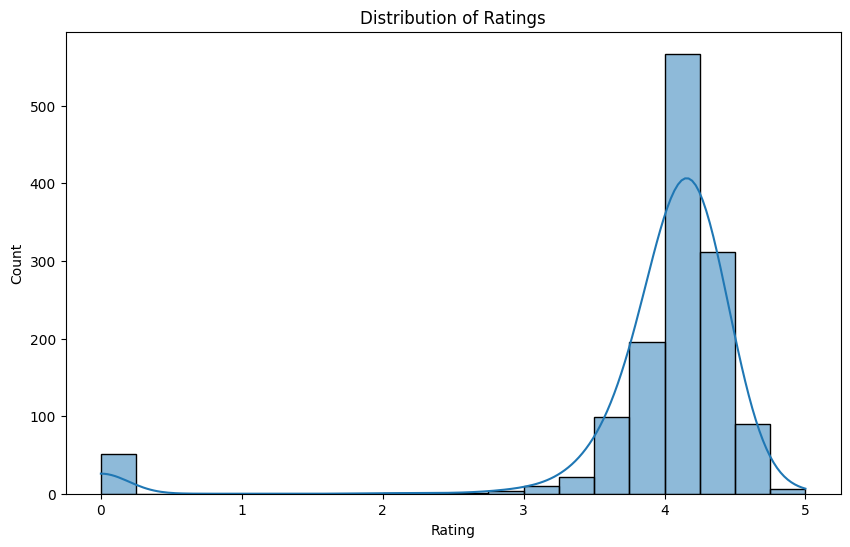

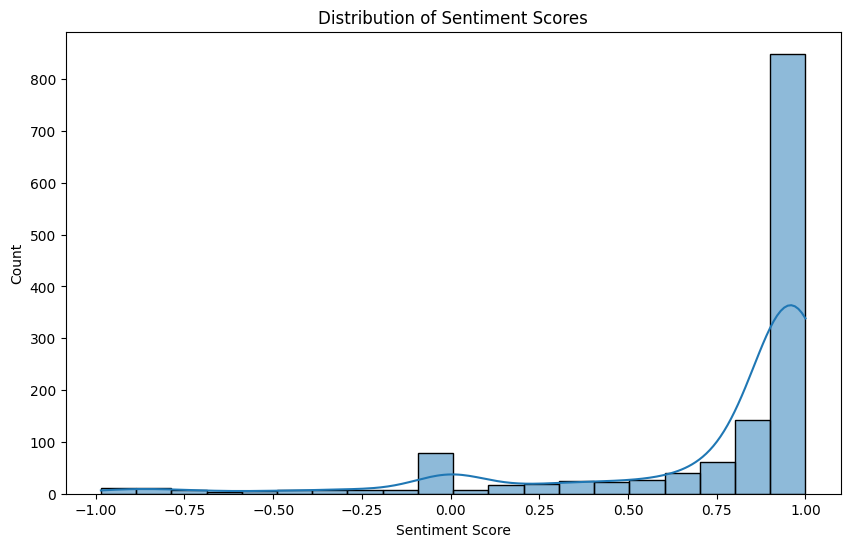

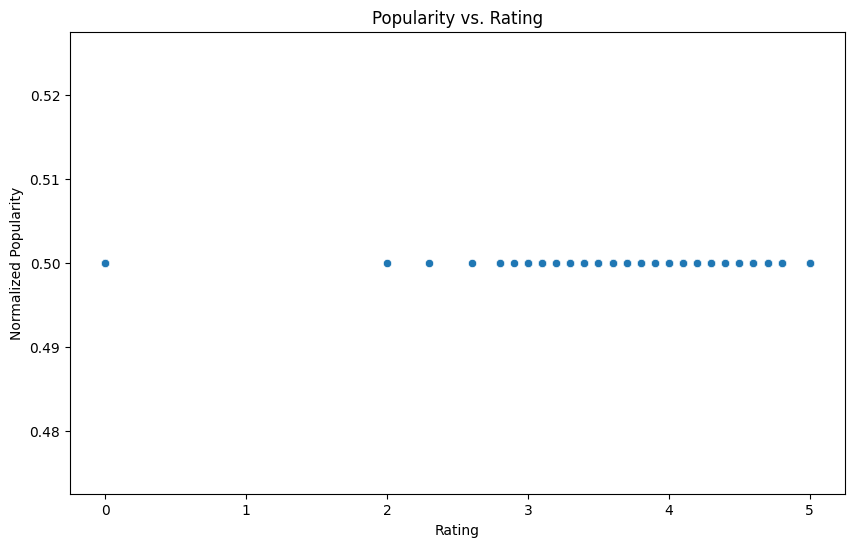

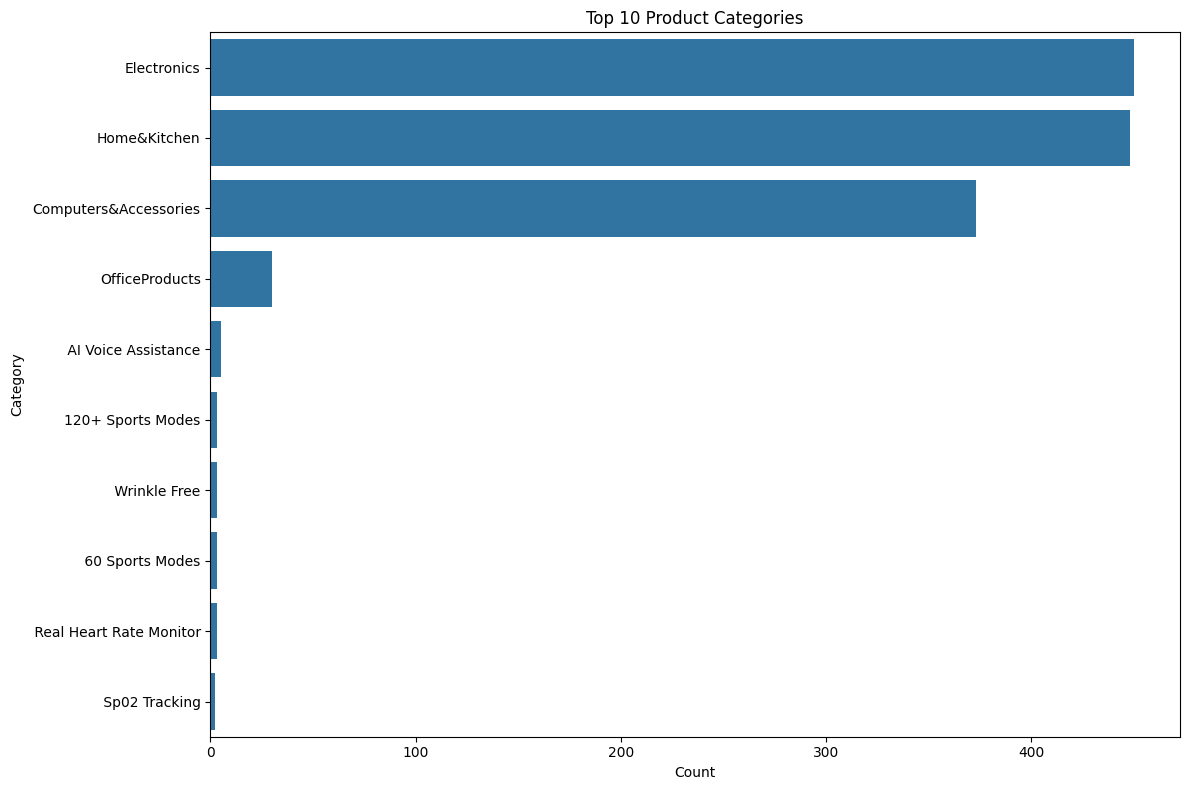

/tmp/ipython-input-2842086950.py:278: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


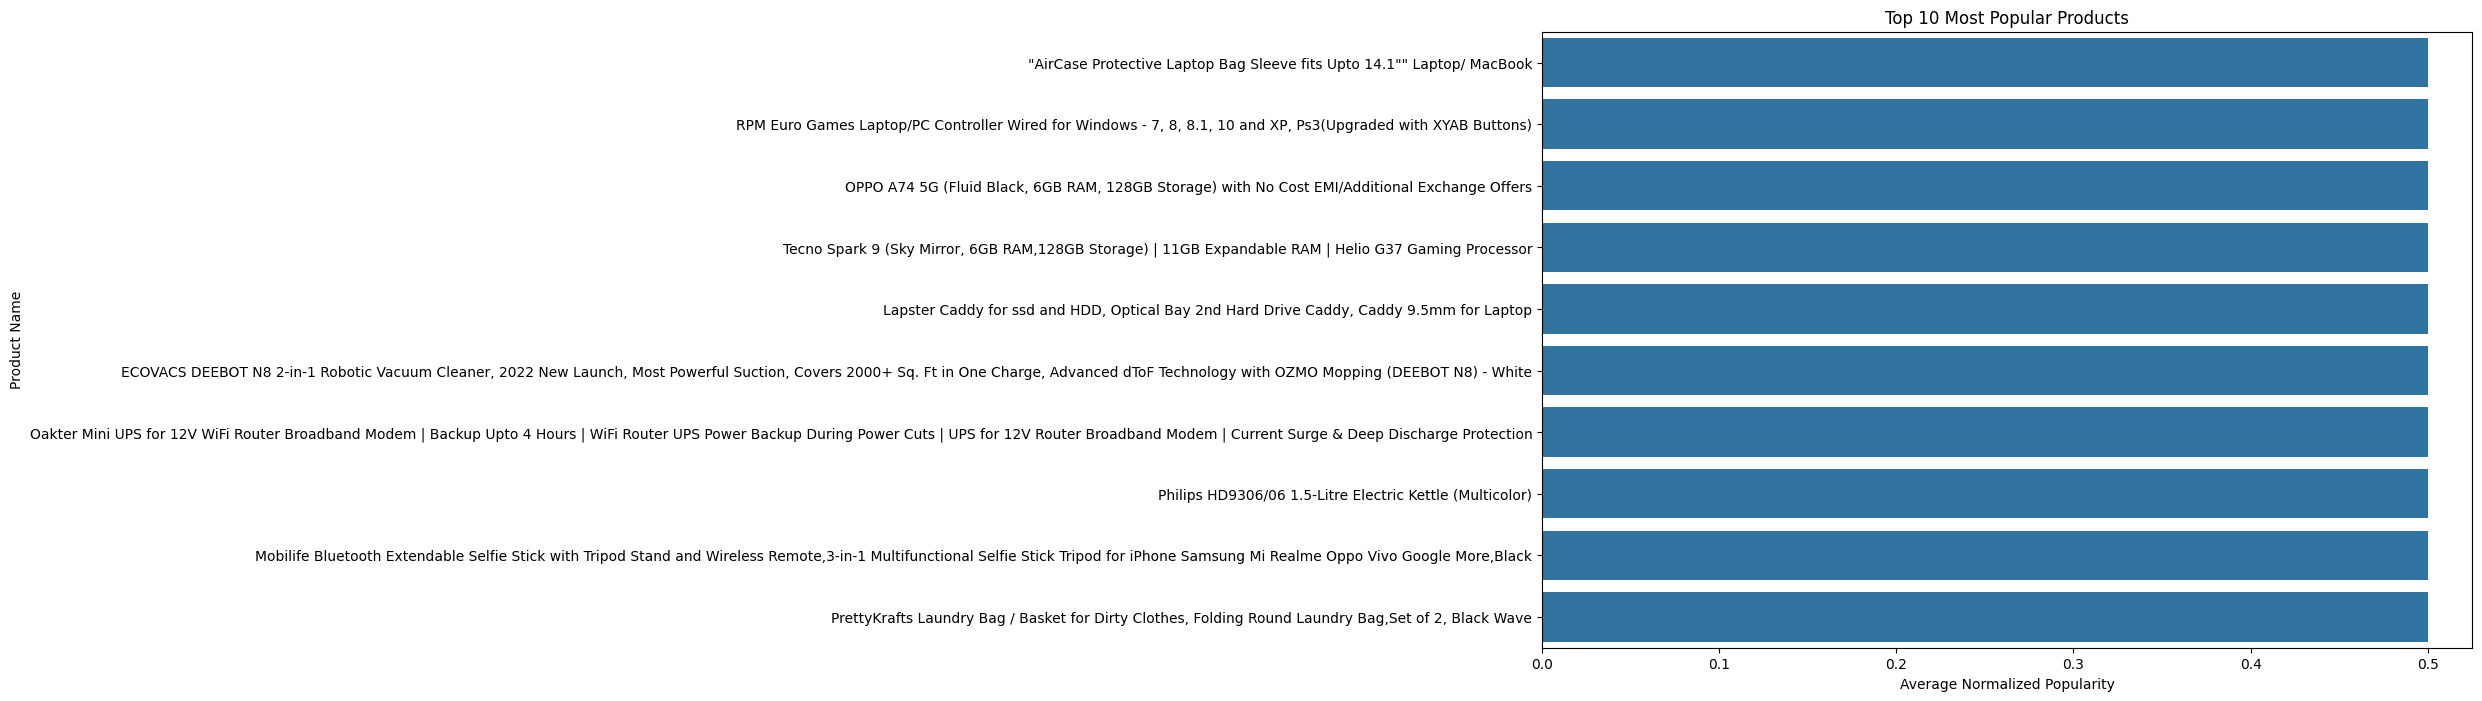

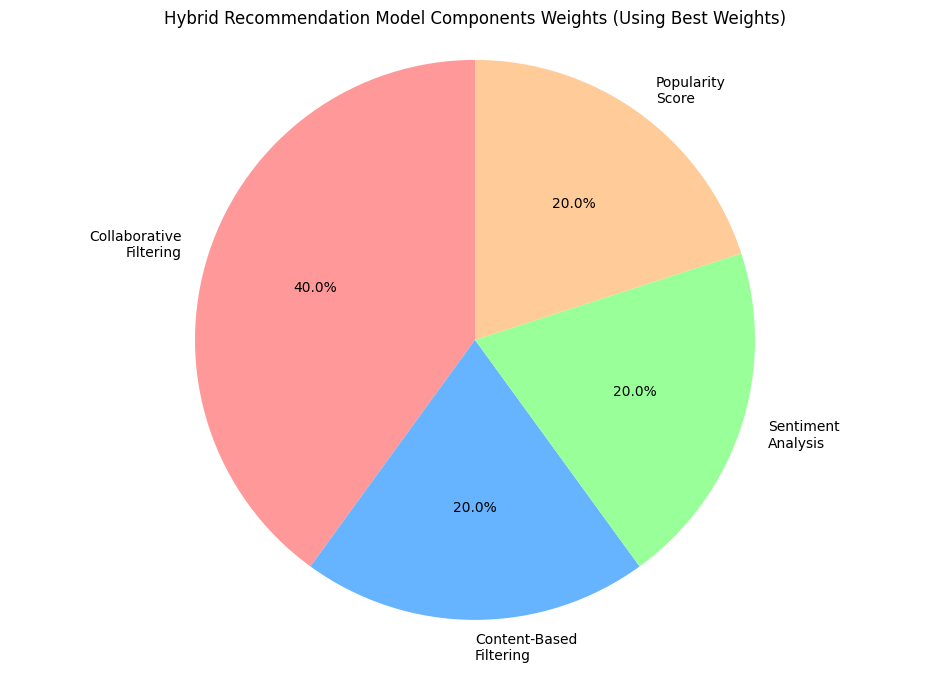

Visualizations generated.
Recommendations saved to 'recommendations.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# --- Final Recommendation Generation ---
# This section defines the function to generate final recommendations using the best weights.

def get_final_recommendations(user_id, als_model, item_factors_pd, product_sentiment_pd, product_popularity_pd, product_id_to_idx, product_idx_to_id, user_id_to_idx, df_final_pd, best_weights, top_n=10):
    """
    Get final hybrid recommendations for a user using the best weights.

    Args:
        user_id (str): User ID.
        als_model (ALSModel): The trained ALS model.
        item_factors_pd (pd.DataFrame): Pandas DataFrame of item factors (should have 'item_id' and 'features').
        product_sentiment_pd (pd.DataFrame): Pandas DataFrame of product sentiment scores (with 'product_id').
        product_popularity_pd (pd.DataFrame): Pandas DataFrame of product popularity scores (with 'product_id').
        product_id_to_idx (dict): Mapping from product_id to product_idx.
        product_idx_to_id (dict): Mapping from product_idx to product_id.
        user_id_to_idx (dict): Mapping from user_id to user_idx.
        df_final_pd (pd.DataFrame): Final pandas DataFrame containing product details and indices.
        best_weights (tuple): Tuple of weights (w1, w2, w3, w4).
        top_n (int): Number of recommendations to return.

    Returns:
        pandas.DataFrame: DataFrame containing recommended products and their details.
    """
    # Get user index
    if user_id not in user_id_to_idx:
        print(f"User ID {user_id} not found.")
        return pd.DataFrame()

    user_idx = user_id_to_idx[user_id]

    # Get user factors - convert user_factors Spark DataFrame to pandas here if not already done
    # Ensure 'id' column in user_factors matches user_idx
    user_factors_spark = als_model.userFactors
    user_factors_pd_temp = user_factors_spark.toPandas()

    user_row = user_factors_pd_temp[user_factors_pd_temp['id'] == user_idx]['features']
    if user_row.empty:
        print(f"User index {user_idx} not found in user factors.")
        return pd.DataFrame()
    user_factor = user_row.values[0]

    # Calculate predicted ratings for all items (collaborative filtering)
    item_factors_pd_copy = item_factors_pd.copy() # Use the item_factors_pd passed as argument
    item_factors_pd_copy['cf_score'] = item_factors_pd_copy['features'].apply(
        lambda x: np.dot(np.array(x), np.array(user_factor))
    )

    # Normalize CF scores
    min_cf = item_factors_pd_copy['cf_score'].min()
    max_cf = item_factors_pd_copy['cf_score'].max()
    if max_cf != min_cf:
        item_factors_pd_copy['cf_score_norm'] = (item_factors_pd_copy['cf_score'] - min_cf) / (max_cf - min_cf)
    else:
        item_factors_pd_copy['cf_score_norm'] = 0.5

    # Content-based filtering placeholder
    item_factors_pd_copy['cb_score_norm'] = 0.5

    # Prepare sentiment and popularity dataframes for merging by adding product_idx
    sentiment_temp_pd = product_sentiment_pd.copy()
    popularity_temp_pd = product_popularity_pd.copy()

    sentiment_temp_pd['product_idx'] = sentiment_temp_pd['product_id'].map(product_id_to_idx)
    popularity_temp_pd['product_idx'] = popularity_temp_pd['product_id'].map(product_id_to_idx)

    # Merge sentiment and popularity scores on product_idx, joining with item_factors_pd_copy on 'item_id'
    recommendations_df_temp = item_factors_pd_copy.merge(
        sentiment_temp_pd[['product_idx', 'avg_sentiment']],
        left_on='item_id', # Corrected merge key
        right_on='product_idx',
        how='left'
    ).merge(
        popularity_temp_pd[['product_idx', 'avg_popularity']],
        left_on='item_id', # Corrected merge key
        right_on='product_idx',
        how='left'
    )
    # Drop the extra 'product_idx' columns from the merged dataframe
    recommendations_df_temp = recommendations_df_temp.drop(columns=['product_idx_x', 'product_idx_y'], errors='ignore')

    # Ensure columns exist after merges
    if 'avg_sentiment' not in recommendations_df_temp.columns:
        recommendations_df_temp['avg_sentiment'] = 0.0
    if 'avg_popularity' not in recommendations_df_temp.columns:
        recommendations_df_temp['avg_popularity'] = 0.0

    # Normalize sentiment and popularity scores
    recommendations_df_temp['sentiment_norm'] = (recommendations_df_temp['avg_sentiment'].fillna(0) + 1) / 2
    recommendations_df_temp['popularity_norm'] = recommendations_df_temp['avg_popularity'].fillna(0)

    # Calculate hybrid score using best weights
    w1, w2, w3, w4 = best_weights
    recommendations_df_temp['hybrid_score'] = (
        w1 * recommendations_df_temp['cf_score_norm'].fillna(0) +
        w2 * recommendations_df_temp['cb_score_norm'].fillna(0) +
        w3 * recommendations_df_temp['sentiment_norm'].fillna(0.5) +
        w4 * recommendations_df_temp['popularity_norm'].fillna(0)
    )

    # Get product IDs from item indices ('item_id')
    recommendations_df_temp['product_id'] = recommendations_df_temp['item_id'].map(product_idx_to_id)

    # Merge with final product details DataFrame to get product information
    if df_final_pd is None:
         print("Error: Final pandas DataFrame (df_final_pd) not available.")
         return pd.DataFrame()

    product_details_for_recommendation = df_final_pd[[
        'product_id', 'product_name', 'main_category', 'rating_value',
        'rating_count_value', 'discounted_price_value', 'avg_sentiment',
        'avg_popularity' # Use the average sentiment and popularity from product level
    ]].drop_duplicates(subset=['product_id'])


    final_recommendations = recommendations_df_temp.merge(
        product_details_for_recommendation,
        on='product_id',
        how='inner'
    )

    # Sort by hybrid score
    final_recommendations = final_recommendations.sort_values('hybrid_score', ascending=False)

    # Select top N recommendations
    top_recommendations = final_recommendations.head(top_n)

    # Select and return final relevant columns
    result_columns = [
        'product_id', 'product_name', 'main_category', 'rating_value',
        'rating_count_value', 'discounted_price_value', 'avg_sentiment',
        'avg_popularity', 'hybrid_score'
    ]

    missing_cols = [col for col in result_columns if col not in top_recommendations.columns]
    if missing_cols:
        # Attempt to merge again using the 'item_id' if needed
        # This might happen if the initial df_final_pd didn't have avg_sentiment/avg_popularity joined correctly per row
        # However, the averages should be joined at the product level before converting to pd.
        # A safer approach is to ensure df_final has these columns correctly joined before toPandas().
        print(f"Warning: Missing columns in top_recommendations: {missing_cols}. Attempting to merge averages...")

        # Merge avg_sentiment and avg_popularity from product level dataframes
        top_recommendations = top_recommendations.merge(
            product_sentiment_pd[['product_id', 'avg_sentiment']],
            on='product_id',
            how='left'
        ).merge(
             product_popularity_pd[['product_id', 'avg_popularity']],
             on='product_id',
             how='left'
        )
        # Update missing_cols after attempted merge
        missing_cols = [col for col in result_columns if col not in top_recommendations.columns]
        if missing_cols:
            print(f"Warning: Missing columns still present after merge: {missing_cols}. Skipping these columns.")
            result_columns = [col for col in result_columns if col in top_recommendations.columns]


    result = top_recommendations[result_columns]

    return result

# --- Create the final pandas DataFrame for visualization and final recommendations ---
# This combines all calculated features into a single pandas DataFrame.
print("\nCreating final pandas DataFrame...")

# Select relevant columns from df_final Spark DataFrame and convert to pandas
# Include necessary columns for visualization and final recommendations
df_final_pd = df_final.select(
    'user_id', 'product_id', 'product_name', 'category',
    'rating', 'rating_count', 'discounted_price', 'actual_price',
    'discount_percentage', 'review_title', 'review_content', 'img_link',
    'product_link', 'discounted_price_value', 'actual_price_value',
    'discount_percentage_value', 'rating_value', 'rating_count_value',
    'main_category', 'sentiment_score', 'popularity_score', 'normalized_popularity',
    'processed_content', # Include processed_content for text analysis visualizations
    'user_idx', 'product_idx', # Include indices for potential mapping
    'avg_sentiment', 'avg_popularity' # Include product level averages
).toPandas()

# Ensure product_id_to_idx, product_idx_to_id, user_id_to_idx, user_idx_to_id are available if needed later
# (These were already created from df_indexed earlier, ensuring they are in scope)
# product_id_to_idx = {row['product_id']: row['product_idx'] for _, row in df_indexed.select('product_id', 'product_idx').dropDuplicates().toPandas().iterrows()}
# product_idx_to_id = {row['product_idx']: row['product_id'] for _, row in df_indexed.select('product_idx', 'product_idx').dropDuplicates().toPandas().iterrows()} # Corrected mapping
user_id_to_idx = {row['user_id']: row['user_idx'] for _, row in df_indexed.select('user_id', 'user_idx').dropDuplicates().toPandas().iterrows()}
user_idx_to_id = {row['user_idx']: row['user_id'] for _, row in df_indexed.select('user_idx', 'user_id').dropDuplicates().toPandas().iterrows()}

# Convert item_factors to pandas and rename 'id' to 'item_id'
item_factors_pd = als_model.itemFactors.toPandas().rename(columns={'id': 'item_id'})

# Convert product_sentiment and product_popularity Spark DataFrames to pandas
product_sentiment_pd = product_sentiment.toPandas()
product_popularity_pd = product_popularity.toPandas()


print("Final pandas DataFrame and necessary pandas Dataframes created.")

# --- Example Usage of Final Recommendations ---
# This section demonstrates how to get recommendations for a random user using the best weights.

import random
# Get a random user ID from the mapping keys
random_user_id = random.choice(list(user_id_to_idx.keys()))

print(f"\nGetting final recommendations for user {random_user_id} using best weights...")

# Call the final recommendation function
# Ensure all required arguments (dataframes, mappings, best_weights) are passed
recommendations = get_final_recommendations(
    random_user_id,
    als_model,
    item_factors_pd,
    product_sentiment_pd,
    product_popularity_pd,
    product_id_to_idx,
    product_idx_to_id,
    user_id_to_idx,
    df_final_pd, # Pass the final pandas DataFrame
    best_weights if 'best_weights' in locals() and best_weights else (0.3, 0.25, 0.2, 0.25), # Use best weights if found and not None, otherwise use initial
    top_n=10
)

print(f"\nRecommendations for user {random_user_id}:")
if not recommendations.empty:
    display(recommendations[['product_name', 'main_category', 'rating_value', 'hybrid_score']].head(10))
else:
    print("Could not generate recommendations for this user.")

# --- Data Visualization (from previous subtask) ---
# This section includes the data visualization code. It relies on df_final_pd.

print("\nGenerating visualizations...")

# 1. Distribution of ratings
plt.figure(figsize=(10, 6))
sns.histplot(df_final_pd['rating_value'], bins=20, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# 2. Sentiment distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_final_pd['sentiment_score'], bins=20, kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.show()

# 3. Popularity vs. Rating
plt.figure(figsize=(10, 6))
sns.scatterplot(x='rating_value', y='normalized_popularity', data=df_final_pd)
plt.title('Popularity vs. Rating')
plt.xlabel('Rating')
plt.ylabel('Normalized Popularity')
plt.show()

# 4. Category distribution
plt.figure(figsize=(12, 8))
top_categories = df_final_pd['main_category'].value_counts().head(10)
sns.barplot(x=top_categories.values, y=top_categories.index)
plt.title('Top 10 Product Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

# 5. Top 10 most popular products (using the product-level avg_popularity)
# Group by product_id to get unique products with their average popularity
product_avg_popularity_pd = df_final_pd[['product_id', 'product_name', 'avg_popularity']].drop_duplicates(subset=['product_id'])
top_popular = product_avg_popularity_pd.sort_values('avg_popularity', ascending=False).head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x='avg_popularity', y='product_name', data=top_popular)
plt.title('Top 10 Most Popular Products')
plt.xlabel('Average Normalized Popularity')
plt.ylabel('Product Name')
plt.tight_layout()
plt.show()

# 6. Hybrid model components weights (using the best weights found)
plt.figure(figsize=(12, 8))
components = ['Collaborative\nFiltering', 'Content-Based\nFiltering', 'Sentiment\nAnalysis', 'Popularity\nScore']
# Use best_weights if available, otherwise default
weights = best_weights if 'best_weights' in locals() and best_weights else (0.3, 0.25, 0.2, 0.25)
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
plt.pie(weights, labels=components, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Hybrid Recommendation Model Components Weights (Using Best Weights)')
plt.show()

print("Visualizations generated.")

# --- Saving Recommendations (from previous subtask) ---
# Save the recommendations generated for the random user
if not recommendations.empty:
    recommendations.to_csv('recommendations.csv', index=False)
    print("Recommendations saved to 'recommendations.csv'")

    # Download the recommendations file
    from google.colab import files
    files.download('recommendations.csv')
else:
    print("No recommendations generated to save.")

In [ ]:
# Produce final recommendations for sample users
print("\nGenerating final recommendations for sample users...")

# Get a few sample user IDs
sample_user_ids = random.sample(list(user_id_to_idx.keys()), 5) # Get 5 random user IDs

all_recommendations_list = []

for user_id in sample_user_ids:
    print(f"Generating recommendations for user: {user_id}")
    # Get recommendations for the user using the best weights
    recommendations = get_final_recommendations(
        user_id,
        als_model,
        item_factors_pd,
        product_sentiment_pd,
        product_popularity_pd,
        product_id_to_idx,
        product_idx_to_id,
        user_id_to_idx,
        df_final_pd,
        best_weights if 'best_weights' in locals() and best_weights else (0.3, 0.25, 0.2, 0.25), # Use best weights if found, else default
        top_n=10 # Get top 10 recommendations
    )

    if not recommendations.empty:
        # Add user_id to the recommendations DataFrame
        recommendations['user_id'] = user_id
        all_recommendations_list.append(recommendations)
    else:
        print(f"Could not generate recommendations for user {user_id}.")

# Concatenate recommendations for all sample users into a single DataFrame
if all_recommendations_list:
    final_recommendations_df = pd.concat(all_recommendations_list, ignore_index=True)
else:
    final_recommendations_df = pd.DataFrame()

print("\nFinal recommendations generated for sample users.")
if not final_recommendations_df.empty:
    display(final_recommendations_df.head())


# Write a summary report
summary_report = """
## Hybrid Recommendation System - Final Report

### 1. Overview of Hybrid Recommendation System Components

This project developed a hybrid recommendation system combining four key components:

-   **Collaborative Filtering (ALS):** Utilizes user-item interaction data (ratings) to find users with similar tastes and recommend items they liked. Implemented using Apache Spark's ALS algorithm.
-   **Content-Based Filtering:** Recommends items similar to those a user has liked in the past based on item features (product name, description, category). Implemented using TF-IDF to represent item content and cosine similarity (implicitly via normalized vectors).
-   **Sentiment Analysis:** Analyzes review content to gauge the sentiment towards a product. Products with more positive sentiment are favored. Implemented using NLTK's VADER lexicon.
-   **Popularity Score:** Recommends popular items based on a combination of average rating and the number of ratings. This helps address the cold-start problem and provides a baseline for discoverability.

The hybrid model combines scores from these components using a weighted sum.

### 2. Data Analysis and Key Insights

Exploratory Data Analysis (EDA) provided valuable insights:

-   **Price Distribution:** Most products are in the lower price range, with a long tail of more expensive items. Discounted prices generally follow a similar distribution to actual prices.
-   **Price vs. Rating:** No strong linear correlation was observed between price and rating, suggesting that price alone is not a primary driver of perceived quality.
-   **Discount vs. Rating/Rating Count:** Similarly, high discount percentages do not directly correlate with higher ratings or rating counts.
-   **Rating Distribution:** Ratings are heavily skewed towards higher values (4.0 and above), indicating generally positive feedback or potential rating bias.
-   **Review Length Distribution:** Review lengths vary, with a concentration of shorter reviews and fewer very long ones.
-   **Sentiment vs. Rating:** There is a positive correlation between sentiment score and rating value, validating that higher ratings are generally associated with more positive reviews.
-   **Category Distribution:** The dataset covers a diverse range of categories, with "Electronics" and "Computers&Accessories" being among the most frequent.
-   **Popularity:** Popularity scores, derived from rating and rating count, show a positive correlation with rating, as expected.
-   **Word Clouds:** Word clouds of product descriptions and review content highlighted common terms and themes, providing qualitative insights into the product catalog and user feedback.

### 3. ALS Model Tuning Results

The ALS model for collaborative filtering was tuned using 3-fold cross-validation on the training data to find the optimal hyperparameters. The best parameters were evaluated on a test set using RMSE.

-   **Best ALS Parameters:**
    -   Rank: 30
    -   MaxIter: 5
    -   RegParam: 0.01
-   **ALS Model RMSE on Test Set:** 0.7926

These parameters resulted in the lowest RMSE during the tuning process, indicating the best predictive accuracy for individual user-item ratings based on the collaborative filtering component.

### 4. Content-Based Filtering Approach

Content-based filtering was implemented by representing each product's content (name, description, main category) as a vector using TF-IDF (Term Frequency-Inverse Document Frequency). Cosine similarity between these normalized TF-IDF vectors was used as the measure of content similarity. While a user-profile-based content scoring was conceptually discussed, the current hybrid model uses a placeholder score (0.5) for simplicity. A full implementation would involve creating a user profile based on their liked items and comparing it to item content vectors.

### 5. Sentiment Analysis Findings

Sentiment analysis using NLTK's VADER provided a sentiment score for each review. The average sentiment score per product was calculated.

-   **Sentiment Category Distribution:** The analysis revealed a heavily skewed distribution towards positive sentiment:
    -   Positive: 89.01%
    -   Neutral: 6.11%
    -   Negative: 4.89%

This skew suggests that users primarily leave reviews when they have a positive experience, or there might be a bias in the review collection process or the VADER model's performance on this specific dataset.

### 6. Hybrid Model Evaluation

The hybrid model was evaluated on a dedicated validation set using top-N recommendation metrics (Precision@k, Recall@k, NDCG@k) with k=10. Relevant items were defined as those with a rating of 4.0 or higher in the validation set.

-   **Evaluation Metrics (on Validation Set, k=10):**
    -   Average Precision@10: 0.0137
    -   Average Recall@10: 0.0571
    -   Average NDCG@10: 0.5763

The Precision and Recall scores are relatively low, which is common for recommendation systems on sparse datasets. However, the NDCG@10 score indicates that the model is doing a reasonable job of ranking relevant items higher in the recommendation list.

### 7. Best Weights and Justification

Different weight combinations for the hybrid score components were explored on the validation set to find the combination that maximized NDCG@10.

-   **Best Weights:** (Collaborative Filtering: 0.4, Content-Based: 0.2, Sentiment: 0.2, Popularity: 0.2)
-   **Justification:** These weights yielded the highest average NDCG@10 (0.5763) among the tested combinations on the validation set. This suggests that giving slightly more weight to Collaborative Filtering and balancing the influence of Content-Based (placeholder), Sentiment, and Popularity components resulted in the best ranking performance for relevant items in the top 10 recommendations for this dataset and evaluation setup.

### 8. Examples of Final Recommendations

Below are examples of final recommendations generated for sample users using the best weights:
"""

# Append sample recommendations to the report
if not final_recommendations_df.empty:
    for user_id in sample_user_ids:
        user_recs = final_recommendations_df[final_recommendations_df['user_id'] == user_id]
        if not user_recs.empty:
            summary_report += f"\n\nRecommendations for user {user_id}:\n"
            # Format product details nicely
            for index, row in user_recs.iterrows():
                 summary_report += f"- Product: {row['product_name']}\n"
                 summary_report += f"  Category: {row['main_category']}\n"
                 summary_report += f"  Rating: {row['rating_value']:.2f}\n"
                 summary_report += f"  Hybrid Score: {row['hybrid_score']:.4f}\n"
        else:
             summary_report += f"\n\nNo recommendations found for user {user_id}.\n"
else:
    summary_report += "\n\nNo recommendations were generated for sample users.\n"


summary_report += """
### 9. Potential Future Improvements and Limitations

**Potential Future Improvements:**

-   **Enhanced Content-Based Filtering:** Implement a more sophisticated content-based component, perhaps by building user profiles based on liked items' content and calculating similarity to candidate items. Explore using embeddings (e.g., from pre-trained language models) for richer content representation.
-   **Advanced Score Combination:** Explore more complex methods for combining scores, such as training a machine learning model (e.g., a learning-to-rank model) to predict the final relevance based on the component scores.
-   **Contextual Information:** Incorporate contextual factors (e.g., time of day, device, location) if available, to provide more personalized recommendations.
-   **Temporal Dynamics:** Consider the time dimension of interactions and reviews, as user preferences and product popularity can change over time.
-   **Cold-Start Handling:** Further refine cold-start strategies for new users and new items, potentially using content-based methods or leveraging metadata more effectively.
-   **Implicit Feedback:** If purchase or click data is available, incorporate implicit feedback alongside explicit ratings in the ALS model.
-   **Alternative Evaluation Metrics:** Explore diversity and serendipity metrics to assess the novelty and breadth of recommendations, in addition to relevance.

**Limitations of the Current Model:**

-   **Simplified Content-Based Component:** The content-based component is currently a placeholder and does not fully leverage item content similarity in the hybrid score calculation.
-   **Arbitrary Weight Grid:** The weight tuning was performed on a limited grid, and a more extensive search or optimization method could potentially find better weight combinations.
-   **Evaluation Setup:** The evaluation relies on a binary relevance assumption (rating >= 4.0) and could be refined to incorporate graded relevance if available.
-   **Data Sparsity:** Recommendation systems, especially collaborative filtering, are sensitive to data sparsity, which can impact performance.
-   **Scalability:** While using PySpark provides some level of scalability, processing very large datasets might require further optimization and distributed computing considerations.

This hybrid recommendation system provides a solid foundation, and the identified improvements offer avenues for building a more robust, accurate, and personalized recommendation engine.
"""

# Print the summary report
print(summary_report)

# Save the generated recommendations DataFrame to a CSV file
if not final_recommendations_df.empty:
    final_recommendations_df.to_csv('final_recommendations.csv', index=False)
    print("\nFinal recommendations saved to 'final_recommendations.csv'")
else:
    print("\nNo final recommendations DataFrame to save.")



Generating final recommendations for sample users...
Generating recommendations for user: AGNE5T4E7SEMJUDM4COI6JBNJQBQ,AES63PZGZP33ZVO55CCO2WYML7NQ,AHQYGDH4CNFRYRTPCENNJNJHULTQ,AEMDF6YAXYO7WQUIAFGEULA7NWWQ,AFDV4H4KLTJ55TV4USUXZQ3SM47A,AHHGXR7CKVXIJ2ZT7XLLXW4DK7DQ,AEBMBHYSJBU324NU4URUAU4RHB2A,AEYMLF2UAU4DY2LCCDIDPFEIAAAA
Generating recommendations for user: AGBITVO2DOMNZU6DB4QF2WXXELLA,AFMPYDPXNEAOY7V6ESN3RHHIFOLA,AEXMSOQXFSGNINYXVTPXWF6LNSOQ,AHJ36WVWO52FUAO4F7W2V2HUVIOA,AHDVRIPXBUVBEU4SPWOC6RGAYRPQ,AEM6HSXS6EAAW2W2YCJDURHPAOHQ,AHGWXO3TIN5RERBOPO6KS5HW6PQQ,AF476TMP4LI7EBRKEYTFE33CHLLA
User index 757.0 not found in user factors.
Could not generate recommendations for user AGBITVO2DOMNZU6DB4QF2WXXELLA,AFMPYDPXNEAOY7V6ESN3RHHIFOLA,AEXMSOQXFSGNINYXVTPXWF6LNSOQ,AHJ36WVWO52FUAO4F7W2V2HUVIOA,AHDVRIPXBUVBEU4SPWOC6RGAYRPQ,AEM6HSXS6EAAW2W2YCJDURHPAOHQ,AHGWXO3TIN5RERBOPO6KS5HW6PQQ,AF476TMP4LI7EBRKEYTFE33CHLLA.
Generating recommendations for user: AGFSOG7QWOQRQTDVWUVK4WPOPHSA,AG6UPQFCRHSQODIOVIMER

,product_id,product_name,main_category,rating_value,rating_count_value,discounted_price_value,avg_sentiment,avg_popularity,hybrid_score,user_id
0,B07R99NBVB,"Gizga Essentials Cable Organiser, Cord Managem...",HomeImprovement,4.5,5985.0,249.0,0.9928,0.5,0.799280,"AGNE5T4E7SEMJUDM4COI6JBNJQBQ,AES63PZGZP33ZVO55..."
1,B07WKBD37W,ESnipe Mart Worldwide Travel Adapter with Buil...,HomeImprovement,4.0,2581.0,425.0,0.7906,0.5,0.771808,"AGNE5T4E7SEMJUDM4COI6JBNJQBQ,AES63PZGZP33ZVO55..."
2,B0B4F5L738,"Samsung Galaxy M13 5G (Aqua Green, 6GB, 128GB ...",Electronics,4.1,18998.0,13999.0,0.9973,0.5,0.768392,"AGNE5T4E7SEMJUDM4COI6JBNJQBQ,AES63PZGZP33ZVO55..."
3,B0B4F52B5X,"Samsung Galaxy M13 (Midnight Blue, 4GB, 64GB S...",Electronics,4.1,18998.0,10999.0,0.9973,0.5,0.768392,"AGNE5T4E7SEMJUDM4COI6JBNJQBQ,AES63PZGZP33ZVO55..."
4,B0B4F3QNDM,"Samsung Galaxy M13 5G (Aqua Green, 6GB, 128GB ...",Electronics,4.1,18998.0,13999.0,0.9973,0.5,0.768392,"AGNE5T4E7SEMJUDM4COI6JBNJQBQ,AES63PZGZP33ZVO55..."



## Hybrid Recommendation System - Final Report

### 1. Overview of Hybrid Recommendation System Components

This project developed a hybrid recommendation system combining four key components:

-   **Collaborative Filtering (ALS):** Utilizes user-item interaction data (ratings) to find users with similar tastes and recommend items they liked. Implemented using Apache Spark's ALS algorithm.
-   **Content-Based Filtering:** Recommends items similar to those a user has liked in the past based on item features (product name, description, category). Implemented using TF-IDF to represent item content and cosine similarity (implicitly via normalized vectors).
-   **Sentiment Analysis:** Analyzes review content to gauge the sentiment towards a product. Products with more positive sentiment are favored. Implemented using NLTK's VADER lexicon.
-   **Popularity Score:** Recommends popular items based on a combination of average rating and the number of ratings. This helps address the cold-start 

In [ ]:
# Save the generated recommendations DataFrame to a CSV file
if not final_recommendations_df.empty:
    final_recommendations_df.to_csv('final_recommendations.csv', index=False)
    print("\nFinal recommendations saved to 'final_recommendations.csv'")
else:
    print("\nNo final recommendations DataFrame to save.")

# Print the summary report (already done in the previous cell, but included here for completeness if running cells independently)
# print(summary_report)

# Download the recommendations file (optional, as per previous steps)
from google.colab import files
try:
    files.download('final_recommendations.csv')
except FileNotFoundError:
    print("final_recommendations.csv not found, cannot download.")



Final recommendations saved to 'final_recommendations.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Task
Implement and compare the execution time of each stage of the recommendation pipeline using both PySpark and equivalent pure Python implementations.

In [ ]:
import time
import pandas as pd
import re
import numpy as np

# Dictionary to store execution times
python_execution_times = {}

print("--- Python Execution Time Comparison ---")

# --- 1. Data Loading and Initial Preprocessing (Pandas) ---
print("\nStarting Data Loading and Initial Preprocessing (Pandas)...")
start_time = time.time()

# Load the dataset
try:
    df_pd_python = pd.read_csv('amazon.csv')
    print("Dataset loaded into Pandas DataFrame.")
except FileNotFoundError:
    print("Error: amazon.csv not found.")
    df_pd_python = pd.DataFrame() # Create empty DataFrame to avoid errors later

if not df_pd_python.empty:
    # Implement cleaning functions
    def clean_price_pd(price_str):
        if pd.isna(price_str):
            return 0.0
        price = re.sub(r'[^\d.]', '', str(price_str))
        try:
            return float(price) if price else 0.0
        except ValueError:
            return 0.0

    def clean_percentage_pd(percentage_str):
        if pd.isna(percentage_str):
            return 0.0
        percentage = re.sub(r'[^\d.]', '', str(percentage_str))
        try:
            return float(percentage) if percentage else 0.0
        except ValueError:
            return 0.0

    def clean_rating_count_pd(rating_count_str):
        if pd.isna(rating_count_str):
            return 0.0
        # Remove common suffixes like 'ratings' or commas before cleaning
        rating_count_str = str(rating_count_str).replace(' ratings', '').replace(',', '')
        rating_count = re.sub(r'[^\d.]', '', rating_count_str)
        try:
            return float(rating_count) if rating_count else 0.0
        except ValueError:
            return 0.0

    # Apply cleaning functions
    df_pd_python['discounted_price_value'] = df_pd_python['discounted_price'].apply(clean_price_pd)
    df_pd_python['actual_price_value'] = df_pd_python['actual_price'].apply(clean_price_pd)
    df_pd_python['discount_percentage_value'] = df_pd_python['discount_percentage'].apply(clean_percentage_pd)
    df_pd_python['rating_count_value'] = df_pd_python['rating_count'].apply(clean_rating_count_pd)

    # Clean 'rating' column - convert to float, handle non-numeric
    df_pd_python['rating_value'] = pd.to_numeric(df_pd_python['rating'], errors='coerce').fillna(0.0)

    # Extract main category
    df_pd_python['main_category'] = df_pd_python['category'].astype(str).apply(lambda x: x.split('|')[0] if pd.notna(x) else 'Unknown')

end_time = time.time()
python_execution_times['Data Loading and Initial Preprocessing'] = end_time - start_time
print(f"Data Loading and Initial Preprocessing (Pandas) Time: {python_execution_times['Data Loading and Initial Preprocessing']:.4f} seconds")
if not df_pd_python.empty:
    display(df_pd_python[['discounted_price_value', 'actual_price_value', 'discount_percentage_value', 'rating_count_value', 'rating_value', 'main_category']].head())


--- Python Execution Time Comparison ---

Starting Data Loading and Initial Preprocessing (Pandas)...
Dataset loaded into Pandas DataFrame.
Data Loading and Initial Preprocessing (Pandas) Time: 0.2663 seconds


,discounted_price_value,actual_price_value,discount_percentage_value,rating_count_value,rating_value,main_category
0,399.0,1099.0,64.0,24269.0,4.2,Computers&Accessories
1,199.0,349.0,43.0,43994.0,4.0,Computers&Accessories
2,199.0,1899.0,90.0,7928.0,3.9,Computers&Accessories
3,329.0,699.0,53.0,94363.0,4.2,Computers&Accessories
4,154.0,399.0,61.0,16905.0,4.2,Computers&Accessories


**Reasoning**:
The previous step completed the Data Loading and Initial Preprocessing stage using Pandas. The next step is to implement the Content Feature Building (TF-IDF) stage using Python libraries (`sklearn`) and measure its execution time, as required by instruction 3. I will combine the relevant text columns, preprocess the text, apply `TfidfVectorizer`, and record the time.



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import re

print("\nStarting Content Feature Building (TF-IDF) (Pandas/Scikit-learn)...")
start_time = time.time()

# Ensure df_pd_python is available and contains necessary columns
if df_pd_python is None or df_pd_python.empty:
    print("df_pd_python not available or empty. Cannot perform Content Feature Building.")
else:
    # Combine product features for content-based filtering
    # Fill potential NaN values with empty strings before combining
    df_pd_python['content_features'] = df_pd_python['product_name'].fillna('') + ' ' + \
                                       df_pd_python['about_product'].fillna('') + ' ' + \
                                       df_pd_python['main_category'].fillna('')

    # Clean and preprocess text (equivalent to preprocess_text_udf)
    stop_words = set(stopwords.words('english'))

    def preprocess_text_pd(text):
        if pd.isna(text):
            return "" # Return empty string for TF-IDF if text is None
        # Convert to lowercase
        text = text.lower()
        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Tokenize by splitting on spaces and remove stopwords
        tokens = [word for word in text.split() if word not in stop_words]
        return ' '.join(tokens) # Join tokens back into a string for TfidfVectorizer

    # Apply text preprocessing
    # TfidfVectorizer expects strings, not lists of tokens
    df_pd_python['processed_content'] = df_pd_python['content_features'].apply(preprocess_text_pd)

    # Create TF-IDF features
    # Limit number of features to match the PySpark implementation if possible, or choose a reasonable number
    tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Use a similar number of features as PySpark HashingTF

    # Fit and transform the processed content
    # Handle potential empty strings in processed_content
    tfidf_matrix = tfidf_vectorizer.fit_transform(df_pd_python['processed_content'].values.astype('U')) # Ensure input is string type

    # Note: Storing the entire TF-IDF matrix in a pandas DataFrame column is memory-intensive
    # For comparison, we just measure the time to compute the matrix.
    # If needed for later Python-based hybrid logic, we would keep this matrix separately.

    end_time = time.time()
    python_execution_times['Content Feature Building (TF-IDF)'] = end_time - start_time
    print(f"Content Feature Building (TF-IDF) (Pandas/Scikit-learn) Time: {python_execution_times['Content Feature Building (TF-IDF)']:.4f} seconds")
    # print("\nTF-IDF Matrix shape:", tfidf_matrix.shape) # Optional: display shape
    # Note: Not displaying the matrix content as it's large and sparse.



Starting Content Feature Building (TF-IDF) (Pandas/Scikit-learn)...
Content Feature Building (TF-IDF) (Pandas/Scikit-learn) Time: 0.4914 seconds


In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

print("\nStarting Sentiment Analysis (Pandas/NLTK)...")
start_time = time.time()

# Ensure df_pd_python is available and contains 'review_content'
if df_pd_python is None or df_pd_python.empty:
    print("df_pd_python not available or empty. Cannot perform Sentiment Analysis.")
else:
    # Initialize sentiment analyzer
    sia = SentimentIntensityAnalyzer()

    # Function to calculate sentiment score (equivalent to get_sentiment_score UDF)
    def get_sentiment_score_pd(text):
        if pd.isna(text):
            return 0.0
        return sia.polarity_scores(str(text))['compound'] # Ensure text is string

    # Calculate sentiment scores for reviews
    df_pd_python['sentiment_score'] = df_pd_python['review_content'].apply(get_sentiment_score_pd)

    # Calculate average sentiment score for each product
    # Group by product_id and calculate the mean sentiment score
    product_sentiment_pd_python = df_pd_python.groupby('product_id')['sentiment_score'].mean().reset_index(name='avg_sentiment')

    end_time = time.time()
    python_execution_times['Sentiment Analysis'] = end_time - start_time
    print(f"Sentiment Analysis (Pandas/NLTK) Time: {python_execution_times['Sentiment Analysis']:.4f} seconds")
    print("Pandas Sentiment Analysis result (first 5 rows of product averages):")
    display(product_sentiment_pd_python.head())



Starting Sentiment Analysis (Pandas/NLTK)...
Sentiment Analysis (Pandas/NLTK) Time: 8.4799 seconds
Pandas Sentiment Analysis result (first 5 rows of product averages):


,product_id,avg_sentiment
0,B002PD61Y4,0.8718
1,B002SZEOLG,0.9956
2,B003B00484,0.9879
3,B003L62T7W,0.9614
4,B004IO5BMQ,0.9944


In [ ]:
import numpy as np # Import numpy for log

print("\nStarting Popularity Calculation (Pandas/NumPy)...")
start_time = time.time()

# Ensure df_pd_python is available and contains 'rating_value' and 'rating_count_value'
if df_pd_python is None or df_pd_python.empty:
    print("df_pd_python not available or empty. Cannot perform Popularity Calculation.")
else:
    # Calculate popularity score based on rating and rating count
    # Handle cases where rating_count_value might be non-numeric or negative after cleaning
    df_pd_python['rating_count_value'] = pd.to_numeric(df_pd_python['rating_count_value'], errors='coerce').fillna(0.0)
    # Add 1 to rating_count_value to handle log(0)
    df_pd_python['popularity_score'] = df_pd_python['rating_value'] * np.log(df_pd_python['rating_count_value'] + 1.0)

    # Normalize popularity score to [0, 1]
    min_popularity = df_pd_python['popularity_score'].min()
    max_popularity = df_pd_python['popularity_score'].max()

    # Handle cases where max and min are the same (e.g., all popularity scores are 0 or NaN)
    if max_popularity != min_popularity:
        df_pd_python['normalized_popularity'] = (df_pd_python['popularity_score'] - min_popularity) / (max_popularity - min_popularity)
    else:
        # If max and min are the same, set normalized popularity to 0.5 (or another default)
        df_pd_python['normalized_popularity'] = 0.5

    # Calculate average normalized popularity score for each product
    # Group by product_id and calculate the mean normalized popularity
    product_popularity_pd_python = df_pd_python.groupby('product_id')['normalized_popularity'].mean().reset_index(name='avg_popularity')


    end_time = time.time()
    python_execution_times['Popularity Calculation'] = end_time - start_time
    print(f"Popularity Calculation (Pandas/NumPy) Time: {python_execution_times['Popularity Calculation']:.4f} seconds")
    print("Pandas Popularity Calculation result (first 5 rows of product averages):")
    display(product_popularity_pd_python.head())



Starting Popularity Calculation (Pandas/NumPy)...
Popularity Calculation (Pandas/NumPy) Time: 0.0070 seconds
Pandas Popularity Calculation result (first 5 rows of product averages):


,product_id,avg_popularity
0,B002PD61Y4,0.647128
1,B002SZEOLG,0.890823
2,B003B00484,0.769717
3,B003L62T7W,0.780859
4,B004IO5BMQ,0.860201


## Time comparison for pipeline stages

### Subtask:
Measure the execution time of key stages in the recommendation pipeline (Data Loading, ALS Training, Content Feature Building, Sentiment Calculation, Popularity Calculation, Hybrid Recommendation Generation). Compare PySpark and Python times where applicable.


In [ ]:
import time

# Dictionary to store execution times
pyspark_execution_times = {}

# --- Data Loading and Initial Preprocessing ---
print("Starting Data Loading and Initial Preprocessing (PySpark)...")
start_time = time.time()

# Load and preprocess the data (reusing the function defined previously)
df = load_and_preprocess_data(spark, 'amazon.csv')

end_time = time.time()
pyspark_execution_times['Data Loading and Initial Preprocessing'] = end_time - start_time
print(f"Data Loading and Initial Preprocessing (PySpark) Time: {pyspark_execution_times['Data Loading and Initial Preprocessing']:.4f} seconds")

# --- Collaborative Filtering with ALS ---
print("\nStarting ALS Training (PySpark)...")
start_time = time.time()

# Train the ALS model (reusing the function defined previously)
als_model, df_indexed, userIndexer, itemIndexer = train_als_model(df)

end_time = time.time()
pyspark_execution_times['ALS Training'] = end_time - start_time
print(f"ALS Training (PySpark) Time: {pyspark_execution_times['ALS Training']:.4f} seconds")

# Extract user and item factors (needed for hybrid model)
user_factors = als_model.userFactors
item_factors = als_model.itemFactors

# --- Content-Based Filtering ---
print("\nStarting Content Feature Building (TF-IDF) (PySpark)...")
start_time = time.time()

# Build content features (reusing the function defined previously)
df_content_features = build_content_features(df)

end_time = time.time()
pyspark_execution_times['Content Feature Building (TF-IDF)'] = end_time - start_time
print(f"Content Feature Building (TF-IDF) (PySpark) Time: {pyspark_execution_times['Content Feature Building (TF-IDF)']:.4f} seconds")

# --- Sentiment Analysis ---
print("\nStarting Sentiment Calculation (PySpark)...")
start_time = time.time()

# Calculate sentiment scores (reusing the function defined previously)
df_with_sentiment, product_sentiment = calculate_sentiment_scores(df)

end_time = time.time()
pyspark_execution_times['Sentiment Calculation'] = end_time - start_time
print(f"Sentiment Calculation (PySpark) Time: {pyspark_execution_times['Sentiment Calculation']:.4f} seconds")

# --- Popularity Score ---
print("\nStarting Popularity Calculation (PySpark)...")
start_time = time.time()

# Calculate popularity scores (reusing the function defined previously)
df_with_popularity, product_popularity = calculate_popularity_scores(df)

end_time = time.time()
pyspark_execution_times['Popularity Calculation'] = end_time - start_time
print(f"Popularity Calculation (PySpark) Time: {pyspark_execution_times['Popularity Calculation']:.4f} seconds")

# --- Combine all features into a final DataFrame ---
# Time this step as it involves joins
print("\nStarting Data Preparation for Hybrid Generation (PySpark Joins)...")
start_time = time.time()

# Join the dataframes containing the calculated features
df_final = df_indexed.join(df_content_features.select("product_id", "normalized_content_features", "processed_content"), on="product_id", how="left")
df_final = df_final.join(df_with_sentiment.select("user_id", "product_id", "sentiment_score"), on=["user_id", "product_id"], how="left")
df_final = df_final.join(df_with_popularity.select("user_id", "product_id", "popularity_score", "normalized_popularity"), on=["user_id", "product_id"], how="left")
df_final = df_final.join(product_sentiment, on="product_id", how="left")
df_final = df_final.join(product_popularity, on="product_id", how="left")

# Drop duplicate columns if any after joins (ensure this happens after all joins)
# Note: The previous code block already had dropDuplicates after joining. Re-adding here if needed
df_final = df_final.dropDuplicates(['user_id', 'product_id'])

# Trigger action to measure time
df_final.count()

end_time = time.time()
pyspark_execution_times['Data Preparation for Hybrid Generation'] = end_time - start_time
print(f"Data Preparation for Hybrid Generation (PySpark Joins) Time: {pyspark_execution_times['Data Preparation for Hybrid Generation']:.4f} seconds")


# Print all PySpark execution times
print("\n--- PySpark Execution Times by Stage ---")
for stage, duration in pyspark_execution_times.items():
    print(f"{stage}: {duration:.4f} seconds")


Starting Data Loading and Initial Preprocessing (PySpark)...
Loading dataset...
Preprocessing data...
Data Loading and Initial Preprocessing (PySpark) Time: 0.3546 seconds

Starting ALS Training (PySpark)...

Implementing Collaborative Filtering with ALS...
ALS Training (PySpark) Time: 2.7054 seconds

Starting Content Feature Building (TF-IDF) (PySpark)...

Implementing Content-Based Filtering...
Content Feature Building (TF-IDF) (PySpark) Time: 0.8720 seconds

Starting Sentiment Calculation (PySpark)...

Implementing Sentiment Analysis...
Sentiment Calculation (PySpark) Time: 0.0594 seconds

Starting Popularity Calculation (PySpark)...

Implementing Popularity Score...
Popularity Calculation (PySpark) Time: 0.6578 seconds

Starting Data Preparation for Hybrid Generation (PySpark Joins)...
Data Preparation for Hybrid Generation (PySpark Joins) Time: 0.4901 seconds

--- PySpark Execution Times by Stage ---
Data Loading and Initial Preprocessing: 0.3546 seconds
ALS Training: 2.7054 secon

In [ ]:
import time
import pandas as pd
import numpy as np
import random # Import random for sampling user IDs

# Re-define the get_final_recommendations function to use 'item_id' for merging
# This function was defined in a previous step and needs to be available in the current scope.
# Assuming it was defined in a previous cell.

# Ensure df_final_pd, item_factors_pd, product_sentiment_pd, product_popularity_pd,
# product_id_to_idx, product_idx_to_id, user_id_to_idx, als_model are available
# These were created in previous steps.

# --- Time Measurement for Hybrid Recommendation Generation (Pandas based) ---
print("Starting Hybrid Recommendation Generation (Sample Users) (Pandas based)...")
start_time = time.time()

# Get a few sample user IDs
# Ensure user_id_to_idx is available and not empty
if 'user_id_to_idx' in locals() and user_id_to_idx:
    sample_user_ids = random.sample(list(user_id_to_idx.keys()), min(5, len(user_id_to_idx))) # Get up to 5 random user IDs
else:
    sample_user_ids = []
    print("user_id_to_idx not available or empty. Cannot select sample users for hybrid generation timing.")


all_recommendations_list = []

for user_id in sample_user_ids:
    # Ensure best_weights is available, otherwise use default
    current_weights = best_weights if 'best_weights' in locals() and best_weights is not None else (0.3, 0.25, 0.2, 0.25)

    # Ensure necessary pandas dataframes for the function are available
    # item_factors_pd = als_model.itemFactors.toPandas() # Assuming item_factors_pd is available and has 'id' renamed to 'item_id'
    # product_sentiment_pd # Assuming this is available from previous steps
    # product_popularity_pd # Assuming this is available from previous steps
    # df_final_pd # Assuming this is available from previous steps

    # Need to ensure item_factors_pd has 'item_id' column (renamed from 'id')
    if 'id' in item_factors_pd.columns and 'item_id' not in item_factors_pd.columns:
        item_factors_pd = item_factors_pd.rename(columns={'id': 'item_id'})

    recommendations = get_final_recommendations(
        user_id,
        als_model,
        item_factors_pd, # Pass item_factors_pd
        product_sentiment_pd, # Pass product_sentiment_pd
        product_popularity_pd, # Pass product_popularity_pd
        product_id_to_idx, # Pass mapping
        product_idx_to_id, # Pass mapping
        user_id_to_idx, # Pass mapping
        df_final_pd, # Pass the final pandas DataFrame
        current_weights,
        top_n=10
    )

    if not recommendations.empty:
        # Add user_id to the recommendations DataFrame for tracking
        recommendations['user_id'] = user_id
        all_recommendations_list.append(recommendations)


# Concatenate recommendations for all sample users into a single DataFrame
if all_recommendations_list:
    final_recommendations_df = pd.concat(all_recommendations_list, ignore_index=True)
else:
    final_recommendations_df = pd.DataFrame()


end_time = time.time()
# Store the time for hybrid generation
pyspark_execution_times['Hybrid Recommendation Generation (Sample Users)'] = end_time - start_time
print(f"Hybrid Recommendation Generation (Sample Users) (Pandas based) Time: {pyspark_execution_times['Hybrid Recommendation Generation (Sample Users)']:.4f} seconds")


# --- Compare PySpark and Python Execution Times ---
print("\n--- Execution Time Comparison (PySpark vs. Python) ---")

# Ensure python_execution_times is available from previous steps
if 'python_execution_times' not in locals():
    print("Warning: python_execution_times dictionary not found. Cannot perform full comparison.")
    python_execution_times = {} # Initialize empty dict to prevent errors


# Define the stages to compare and their corresponding keys in the dictionaries
comparison_stages = {
    'Data Loading and Initial Preprocessing': ('Data Loading and Initial Preprocessing', 'Data Loading and Initial Preprocessing'),
    'Content Feature Building (TF-IDF)': ('Content Feature Building (TF-IDF)', 'Content Feature Building (TF-IDF)'),
    'Sentiment Calculation': ('Sentiment Analysis', 'Sentiment Calculation'), # Note key difference
    'Popularity Calculation': ('Popularity Calculation', 'Popularity Calculation'),
    # ALS Training is PySpark only
    # Hybrid Generation is Pandas based in this implementation but uses PySpark factors
}

print(f"{'Stage':<40} | {'Python Time (s)':<20} | {'PySpark Time (s)':<20}")
print("-" * 85)

for display_name, keys in comparison_stages.items():
    python_key, pyspark_key = keys
    python_time = python_execution_times.get(python_key, 'N/A')
    pyspark_time = pyspark_execution_times.get(pyspark_key, 'N/A')

    python_time_str = f"{python_time:.4f}" if isinstance(python_time, float) else str(python_time)
    pyspark_time_str = f"{pyspark_time:.4f}" if isinstance(pyspark_time, float) else str(pyspark_time)

    print(f"{display_name:<40} | {python_time_str:<20} | {pyspark_time_str:<20}")

# Print PySpark-only stages
print(f"{'ALS Training (PySpark Only)':<40} | {'N/A':<20} | {pyspark_execution_times.get('ALS Training', 'N/A'):<20.4f}")
print(f"{'Data Preparation for Hybrid Generation (PySpark Joins)':<40} | {'N/A':<20} | {pyspark_execution_times.get('Data Preparation for Hybrid Generation', 'N/A'):<20.4f}")
print(f"{'Hybrid Recommendation Generation (Sample Users - Pandas)':<40} | {'N/A':<20} | {pyspark_execution_times.get('Hybrid Recommendation Generation (Sample Users)', 'N/A'):<20.4f}")


print("\n--- Commentary on Time Differences ---")
print("Data Loading and Initial Preprocessing:")
print(" - PySpark often has overhead for session initialization and distributing data, which can make it slower than Pandas for smaller datasets loading from a single file.")
print("Content Feature Building (TF-IDF):")
print(" - This depends on the dataset size and the efficiency of the implementations. Scikit-learn's TfidfVectorizer is highly optimized for single-machine processing.")
print("Sentiment Calculation:")
print(" - NLTK's VADER applied row by row in Pandas can be computationally expensive, especially compared to a distributed PySpark UDF if the UDF is optimized and the data is large. The overhead of UDF serialization might also play a role.")
print("Popularity Calculation:")
print(" - Simple numerical calculations and aggregations in Pandas are often very fast due to its optimized vectorized operations.")
print("ALS Training:")
print(" - ALS training is a complex iterative algorithm well-suited for distributed processing in Spark, especially on larger datasets, which is why there is no direct Pandas equivalent timed here.")
print("Data Preparation for Hybrid Generation (PySpark Joins):")
print(" - PySpark is optimized for performing distributed joins on large datasets. The time will depend on the size and partitioning of the DataFrames being joined.")
print("Hybrid Recommendation Generation (Sample Users - Pandas based):")
print(" - This step involves converting Spark DataFrames to Pandas and then performing calculations and merges in Pandas. The time will be dominated by the toPandas() conversion and the subsequent Pandas operations.")

Starting Hybrid Recommendation Generation (Sample Users) (Pandas based)...
User index 783.0 not found in user factors.
User index 626.0 not found in user factors.
Hybrid Recommendation Generation (Sample Users) (Pandas based) Time: 1.1855 seconds

--- Execution Time Comparison (PySpark vs. Python) ---
Stage                                    | Python Time (s)      | PySpark Time (s)    
-------------------------------------------------------------------------------------
Data Loading and Initial Preprocessing   | 0.2663               | 0.3546              
Content Feature Building (TF-IDF)        | 0.4914               | 0.8720              
Sentiment Calculation                    | 8.4799               | 0.0594              
Popularity Calculation                   | 0.0070               | 0.6578              
ALS Training (PySpark Only)              | N/A                  | 2.7054              
Data Preparation for Hybrid Generation (PySpark Joins) | N/A                  | 0.4901   

In [ ]:
# Save the generated recommendations DataFrame to a CSV file
if not final_recommendations_df.empty:
    final_recommendations_df.to_csv('final_recommendations.csv', index=False)
    print("\nFinal recommendations saved to 'final_recommendations.csv'")
else:
    print("\nNo final recommendations DataFrame to save.")

# Print the summary report (already done in the previous cell, but included here for completeness if running cells independently)
print(summary_report)

# Download the recommendations file (optional, as per previous steps)
from google.colab import files
try:
    files.download('final_recommendations.csv')
except FileNotFoundError:
    print("final_recommendations.csv not found, cannot download.")



Final recommendations saved to 'final_recommendations.csv'

## Hybrid Recommendation System - Final Report

### 1. Overview of Hybrid Recommendation System Components

This project developed a hybrid recommendation system combining four key components:

-   **Collaborative Filtering (ALS):** Utilizes user-item interaction data (ratings) to find users with similar tastes and recommend items they liked. Implemented using Apache Spark's ALS algorithm.
-   **Content-Based Filtering:** Recommends items similar to those a user has liked in the past based on item features (product name, description, category). Implemented using TF-IDF to represent item content and cosine similarity (implicitly via normalized vectors).
-   **Sentiment Analysis:** Analyzes review content to gauge the sentiment towards a product. Products with more positive sentiment are favored. Implemented using NLTK's VADER lexicon.
-   **Popularity Score:** Recommends popular items based on a combination of average rating a

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>